1 - Import Required Packages

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
from sklearn.decomposition import PCA, SparsePCA
import re
from datetime import datetime
from dateutil.parser import parse
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

pd.set_option('max_columns',None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

2 - Define custom-made functions

In [2]:
def processing(img,height=int,width=int):
    dim = (width,height)
    size =  cv2.resize(img,dim, interpolation=cv2.INTER_LINEAR)
    norm = np.zeros((100, 100))
    norm_img = cv2.normalize(size, norm, 0, 100, cv2.NORM_MINMAX)
    
    return  norm_img

def get_images():
    df = pd.DataFrame(columns=['App','original_image','blue_channel','green_channel','red_channel'])

    app_images = [x for x in os.listdir(('/Users/agustinferreira/Desktop/finalproyect-stats/data/images/')) if str(x) != '.DS_Store']

    for image in app_images:
        try: 
            
            crude  = np.asarray(cv2.cvtColor(cv2.imread(f'/Users/agustinferreira/Desktop/finalproyect-stats/data/images/{image}'), cv2.COLOR_BGR2RGB)) #transforming image to array and RGB color scale
            processed_img = processing(crude,100,100) #resizing and normalizing image
            blue_channel,green_channel,red_channel = cv2.split(processed_img)
        except IOError:
            pass
        image_name = image[:-4]
        df = df.append({'App' : image_name, 'original_image':processed_img, 'blue_channel':blue_channel, 'green_channel':green_channel,'red_channel':red_channel} , ignore_index=True)
    return df

app_data = pd.read_csv('/Users/agustinferreira/Desktop/finalproyect-stats/data/app_sample.csv')

app_images = get_images()

#Plot image decomposition in RGB filtering

def plot_img_decomposition(figureindex:int=1):
    
    fig = plt.figure(figsize = (15, 7.2))
    fig.add_subplot(141)
    plt.title("Original Image")
    plt.imshow(Image.fromarray(data_complete.iloc[figureindex,69]))
    fig.add_subplot(142)
    plt.title("Blue Channel")
    plt.imshow(Image.fromarray(data_complete.iloc[figureindex,70]))
    fig.add_subplot(143)
    plt.title("Green Channel")
    plt.imshow(Image.fromarray(data_complete.iloc[figureindex,71]))
    fig.add_subplot(144)
    plt.title("Red Channel")
    plt.imshow(Image.fromarray(data_complete.iloc[figureindex,72]))
    return plt.show(fig)

def apply_pca(dataframe, n_components:int):

    list_blue = []
    list_green = []
    list_red = []
    expvar_blue = []
    expvar_green = []
    expvar_red = []

    for i in range(dataframe.shape[0]):
        pca_red = PCA(n_components=n_components)
        pca_red.fit(dataframe['blue_channel_scaled'][i])
        list_red.append(pca_red.transform(dataframe['red_channel_scaled'][i]))
        expvar_red.append(sum(pca_red.explained_variance_ratio_))

        pca_blue = PCA(n_components=n_components)
        pca_blue.fit(dataframe['blue_channel_scaled'][i])
        list_blue.append(pca_blue.transform(dataframe['blue_channel_scaled'][i]))
        expvar_blue.append(sum(pca_blue.explained_variance_ratio_))

        pca_green = PCA(n_components=n_components)
        pca_green.fit(dataframe['blue_channel_scaled'][i])
        list_green.append(pca_green.transform(dataframe['green_channel_scaled'][i]))
        expvar_green.append(sum(pca_green.explained_variance_ratio_))

    dataframe['blue_channel_PCA'] = list_blue
    dataframe['green_channel_PCA'] = list_green
    dataframe['red_channel_PCA'] = list_red


    return dataframe,expvar_red,expvar_green,expvar_blue,pca_red,pca_green,pca_blue

def plot_pca(i:int):

    fig = plt.figure(figsize = (15, 7.2))
        
    fig.add_subplot(121)
    plt.title("Original Image")
    plt.imshow(Image.fromarray(data_complete.iloc[i,69]))
    
    fig.add_subplot(122)
    plt.title("PCA Image")
    b_arr = pca_blue.inverse_transform(data_w_pca20['blue_channel_PCA'][i])
    g_arr = pca_green.inverse_transform(data_w_pca20['green_channel_PCA'][i])
    r_arr = pca_red.inverse_transform(data_w_pca20['red_channel_PCA'][i])

    img_reduced= (cv2.merge((b_arr, g_arr, r_arr)))
    plt.imshow(img_reduced)
    
    return plt.show(fig)

### Variable Selection 
from sklearn.feature_selection import mutual_info_classif
### Function to see feature importance and select some if you want 
def selection(data,y,corr_cut):
  ### Calculate Feature Importances
  feature_scores = mutual_info_classif(data, y, random_state=42)
  tabla_seleccion=pd.DataFrame()
  tabla_seleccion['nombres']=data.columns
  tabla_seleccion['scores']=feature_scores
  tabla_seleccion=tabla_seleccion.sort_values('scores',ascending=False).reset_index()
  data=data[tabla_seleccion['nombres']]
  print('aca')
  ### Corrlation Matrix
  mtrx=np.matrix(data.corr())

  final_var=[]
  final_score=[]
  for j,i in enumerate(mtrx):
    diagonal=i[0,0:j].tolist()[0]
    condition=[True if (i>=corr_cut) or (i<=-(corr_cut)) else False for i in diagonal]
    if any(condition):
      a=1
    else: 
      final_var.append(data.columns[j])
      final_score.append(tabla_seleccion['scores'][j])
  tabla_seleccion_final=pd.DataFrame()
  tabla_seleccion_final['nombres']=final_var
  tabla_seleccion_final['scores']=final_score

  return (tabla_seleccion,tabla_seleccion_final)

In [3]:
app_data.describe(percentiles = [0.25,0.4,0.75])

,Unnamed: 0,Rating,Rating Count,Minimum Installs,Maximum Installs,Price
count,10000.00000,9920.00000,9920.00000,10000.00000,10000.00000,10000.00000
mean,1161779.83750,2.22608,1699.17722,296232.58560,429234.57890,0.08250
std,672672.86589,2.10919,29078.31791,14204789.27489,18371075.63620,1.10374
min,51.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,577280.00000,0.00000,0.00000,50.00000,84.00000,0.00000
40%,933511.40000,0.00000,0.00000,100.00000,308.60000,0.00000
50%,1170674.50000,3.00000,6.00000,500.00000,700.50000,0.00000
75%,1739240.00000,4.30000,40.00000,5000.00000,7253.00000,0.00000
max,2312533.00000,5.00000,1953804.00000,1000000000.00000,1494252350.00000,60.00000


In [4]:
app_data_300 = app_data[app_data['Maximum Installs']>300]

In [5]:
app_data_300.describe()

,Unnamed: 0,Rating,Rating Count,Minimum Installs,Maximum Installs,Price
count,6035.00000,6010.00000,6010.00000,6035.00000,6035.00000,6035.00000
mean,1160910.46993,3.29466,2803.73295,490827.92046,711188.47490,0.04590
std,674503.03430,1.69080,37318.13530,18283038.93955,23644620.16347,0.49184
min,51.00000,0.00000,0.00000,100.00000,301.00000,0.00000
25%,576266.50000,3.00000,7.00000,1000.00000,1045.00000,0.00000
50%,1164998.00000,4.00000,24.00000,1000.00000,4240.00000,0.00000
75%,1745672.00000,4.40000,138.00000,10000.00000,27031.50000,0.00000
max,2312527.00000,5.00000,1953804.00000,1000000000.00000,1494252350.00000,13.99000


In [6]:
app_data_final = app_data_300[app_data_300['Rating Count']> 100]


In [7]:
app_data_final[app_data_final['Category']== 'Board'].head()

,Unnamed: 0,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
1838,631825,Gomoku Board - play with your friend & A.I.,com.khgkjg12.gomoku,Board,3.10000,336.00000,"100,000+",100000.00000,270622,True,0.00000,USD,Varies with device,4.1 and up,khgkjg12,https://khgkjg12.blogspot.com/,khgkjg12dev@gmail.com,"Sep 12, 2018","Jul 27, 2019",Everyone,https://khgkjg12dev.blogspot.com/2018/09/blog-...,True,False,False,2021-06-16 06:34:21
2172,554861,Monsters & Generators for D&D,com.manzo.encountergenerator,Board,4.30000,1373.00000,"100,000+",100000.00000,259213,True,0.00000,USD,5.4M,4.0.3 and up,Manolo D'antonio,NaN,manolodantonio@gmail.com,"Mar 8, 2018","Oct 09, 2019",Everyone,https://goo.gl/Nf4gH6,False,False,False,2021-06-16 05:24:32
6104,340267,Mahjong Titans,com.mirenad.mahjongtitans,Board,4.40000,5230.00000,"1,000,000+",1000000.00000,1091116,True,0.00000,USD,Varies with device,Varies with device,Mirenad,http://mirenad.com,public.mirenad@hotmail.com,"Jul 30, 2014","Apr 14, 2019",Everyone,NaN,False,False,False,2021-06-16 02:08:30
9070,2286288,Bingo - Pharaoh's Way,com.starlight.BingoPharaoh,Board,4.40000,7357.00000,"500,000+",500000.00000,604123,True,0.00000,USD,44M,4.1 and up,Starlight Interactive,http://starlight-interactive.blogspot.kr/,camack777@gmail.com,"Dec 8, 2013","Jan 14, 2020",Teen,https://starlight-interactive.blogspot.com,True,True,False,2021-06-16 12:35:49


In [8]:
app_data_final['Big_Category2'] = ['Tools' if i in ['Tools','Communication','Productivity', 'Parenting', 'Maps & Navigation', 'Video Players & Editors', 'Weather', 'House & Home' , 'Personalization' ] 
else 'Games' if i in ['Puzzle', 'Arcade', 'Card', 'Action', 'Simulation', 'Adventure','Racing', 'Role Playing', 'Casino', 'Word','Strategy','Casual','Libraries & Demo', 'Board'] 
else 'Education' if i in ['Education', 'Educational'] 
else  'Business' if i in ['Finance', 'Business'] 
else 'Entertainment' if i in ['Entertainment', 'Music & Audio','Books & Reference', 'Photography', 'News & Magazines', 'Sports', 'Shopping', 'Food & Drink', 'Dating', 'Music', 'Comics' , 'Art & Design'] 
else 'Lifestyle' for i in app_data_final['Category']]


/var/folders/9w/hcnt4bcn71v5lrq56ddjlqt00000gn/T/ipykernel_56397/1904140728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_data_final['Big_Category2'] = ['Tools' if i in ['Tools','Communication','Productivity', 'Parenting', 'Maps & Navigation', 'Video Players & Editors', 'Weather', 'House & Home' , 'Personalization' ]


In [9]:
app_data_final['Big_Category2'].value_counts()

Entertainment    501
Tools            371
Games            358
Lifestyle        232
Education        153
Business         112
Name: Big_Category2, dtype: int64

In [10]:
data = app_data_final

In [11]:
### Handling Size of the app 
data['Size'].value_counts()
data['size_number']=[np.nan if len(re.findall(r'\d*\.?\d+',i))==0 else float(re.findall(r'\d*\.?\d+',i)[0]) for i in data['Size']]
data['size_units']=[np.nan if len(re.findall(r'\d*\.?\d+',i))==0 else re.findall(r'[a-zA-Z]+',i)[0] for i in data['Size']]
data['size_norm']=[i*0.001 if j=='k' else i for i,j in zip(data['size_number'],data['size_units'])]

### Handling the version of the app 
data['version']=[np.nan if i!=i else np.nan if len(re.findall(r'\d*\.?\d+',i))==0 else float(re.findall(r'\d*\.?\d+',i)[0]) for i in data['Minimum Android']]  


/var/folders/9w/hcnt4bcn71v5lrq56ddjlqt00000gn/T/ipykernel_56397/772812193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['size_number']=[np.nan if len(re.findall(r'\d*\.?\d+',i))==0 else float(re.findall(r'\d*\.?\d+',i)[0]) for i in data['Size']]
/var/folders/9w/hcnt4bcn71v5lrq56ddjlqt00000gn/T/ipykernel_56397/772812193.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['size_units']=[np.nan if len(re.findall(r'\d*\.?\d+',i))==0 else re.findall(r'[a-zA-Z]+',i)[0] for i in data['Size']]
/var

In [12]:
### Calculating Time Variables 
### Parsing string to dates
data['Released_1']=[np.nan if i!=i else parse(i) for i in data['Released']]
data['Last_Updated_1']=[np.nan if i!=i else parse(i) for i in data['Last Updated']]
data['Scraped_Time_1']=[np.nan if i!=i else parse(i) for i in data['Scraped Time']]
### days since realise 
data['time_realise']=[(i-j).days for i,j in zip(data['Scraped_Time_1'],data['Released_1'])]
### days since last update 
data['time_updated']=[(i-j).days for i,j in zip(data['Scraped_Time_1'],data['Last_Updated_1'])]
### days from realise to last update 
data['time_realise_update']=[-(i-j) for i,j in zip(data['time_updated'],data['time_realise'])]

### Drop auxiliar variables
data=data.drop(['Unnamed: 0','Installs','Minimum Installs','Currency','Size','Minimum Android','Released','Last Updated','Scraped Time','size_units','size_number','Released_1','Last_Updated_1','Scraped_Time_1'],axis=1)

/var/folders/9w/hcnt4bcn71v5lrq56ddjlqt00000gn/T/ipykernel_56397/1913077987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Released_1']=[np.nan if i!=i else parse(i) for i in data['Released']]
/var/folders/9w/hcnt4bcn71v5lrq56ddjlqt00000gn/T/ipykernel_56397/1913077987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Last_Updated_1']=[np.nan if i!=i else parse(i) for i in data['Last Updated']]
/var/folders/9w/hcnt4bcn71v5lrq56ddjlqt00000gn/T/ipykernel_56397/1913077987.py:5: SettingWithCop

In [13]:
### Continuos Variables
cont=['Rating','Rating Count','Maximum Installs','Price','size_norm','version','time_realise','time_updated','time_realise_update']
cat=['Category','Free','Content Rating','Ad Supported','In App Purchases','Editors Choice','Big_Category2']
keys=['App Name','App Id','Developer Id','Developer Website','Developer Email','Privacy Policy']

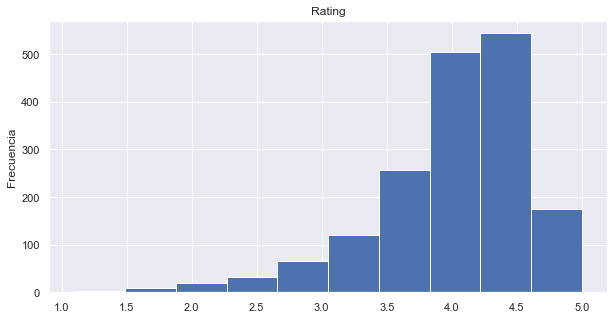

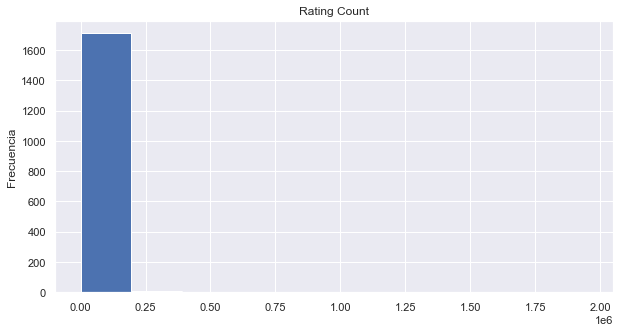

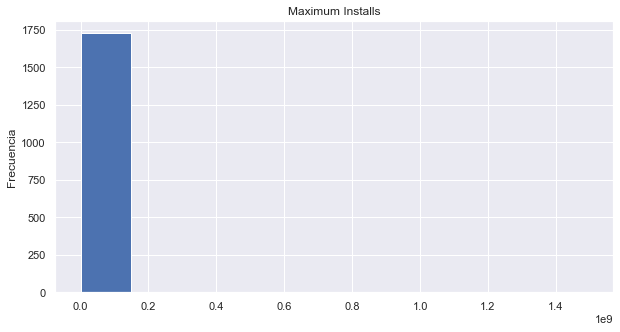

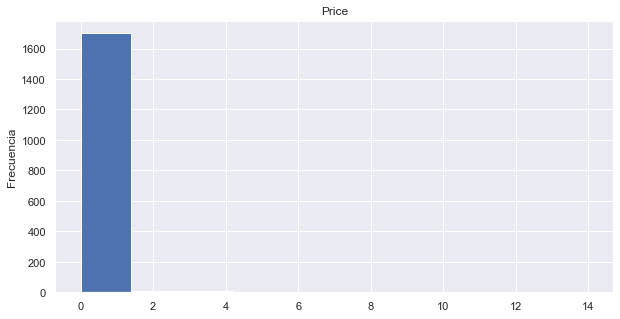

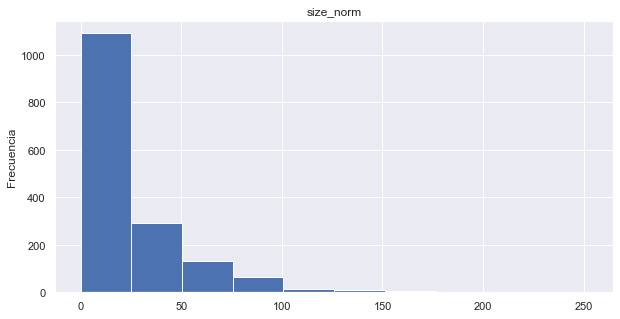

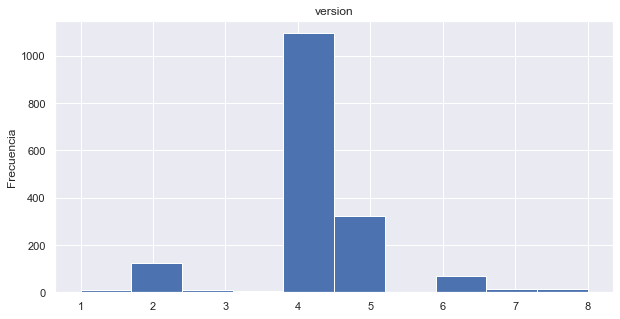

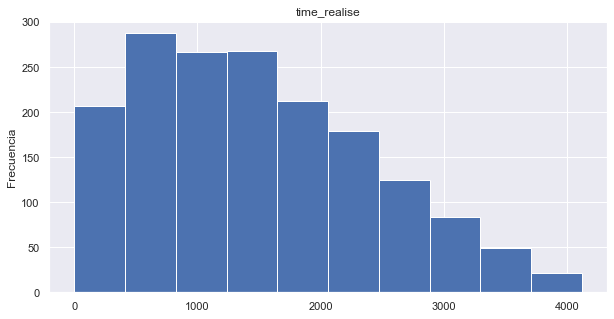

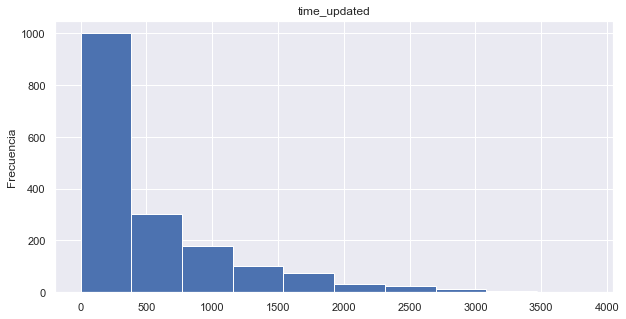

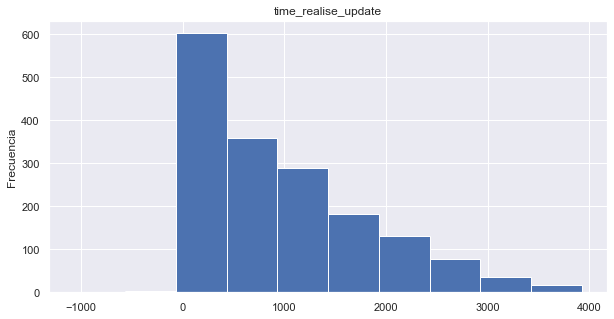

In [14]:
## Univariate Visualization
for i in cont:
  sns.set(rc = {'figure.figsize':(10,5)})
  data[i].hist()
  plt.title(i)
  plt.ylabel('Frecuencia')
  plt.show()

In [15]:
### Barcharts : 
#for i in cat: 
#  aux=data.groupby([i])['App Name'].count().reset_index()
#  sns.barplot(x=aux[i],y=aux['App Name'])
#  plt.title(i)
#  plt.xlabel(i)
#  plt.ylabel('# Of Apps')
#  plt.xticks(rotation=90)
#  plt.show()

In [16]:
### Univariate Visualization
#for i in cont:
#  sns.boxplot(x=data[i])
#  plt.title(i)
#  plt.xlabel(i)
#  plt.show()

In [17]:
### Barcharts : 
#for i in cat: 
#  aux=data.groupby([i])['App Name'].count().reset_index()
#  sns.barplot(x=aux[i],y=aux['App Name'])
#  plt.title(i)
#  plt.xlabel(i)
#  plt.ylabel('# Of Apps')
#  plt.xticks(rotation=90)
#  plt.show()

In [18]:
### Crossed Visualization 
### boxplots for contiuos variables open by categories 
#for i in cont:
#  for j in cat:
#    if j=='Category':
#      sns.set(rc = {'figure.figsize':(7,16)})
#    else: 
#      sns.set(rc = {'figure.figsize':(7,7)})
#    sns.boxplot(x=data[i],y=data[j].astype(str))
#    plt.title(i)
#    plt.xlabel(i)
#    plt.show()

In [19]:
#for i in cont:
#  for j in cont:
#    if i!=j:
#      sns.set(rc = {'figure.figsize':(7,7)})
#      sns.scatterplot(x=data[i], y=data[j])
#      plt.title(i+' vs '+j)
#      plt.show()

In [20]:
# one hot encoding for categorical Variables
data = pd.get_dummies(data, prefix=cat, columns=cat, drop_first = True)## the prefix is how to name the dummies
# Drop Keys
app_list = data['App Name'].reset_index(drop=True)
data=data.drop(keys,axis=1)

In [21]:
### Fill nulls with the mean
# Report na
# Compute nulls per feature
Nulls = data.isnull().sum()
print(Nulls)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')


data_clean = pd.DataFrame(imp_mean.fit_transform(data))
data_clean.columns=data.columns

Rating                           0
Rating Count                     0
Maximum Installs                 0
Price                            0
size_norm                      117
                              ... 
Big_Category2_Education          0
Big_Category2_Entertainment      0
Big_Category2_Games              0
Big_Category2_Lifestyle          0
Big_Category2_Tools              0
Length: 67, dtype: int64


In [22]:
data_clean['App Name'] = app_list

In [23]:
data_complete = data_clean.merge(app_images,how='left', left_on='App Name', right_on='App')
#data_complete.drop(['Unnamed: 0'], axis = 1, inplace = True)

#Scale the colors to take values between 0-1.
data_complete['red_channel_scaled'] = data_complete['red_channel']/100
data_complete['blue_channel_scaled'] = data_complete['blue_channel']/100
data_complete['green_channel_scaled'] = data_complete['green_channel']/100

In [24]:
data_complete.dropna(inplace=True)
data_complete.reset_index(inplace=True, drop=True)

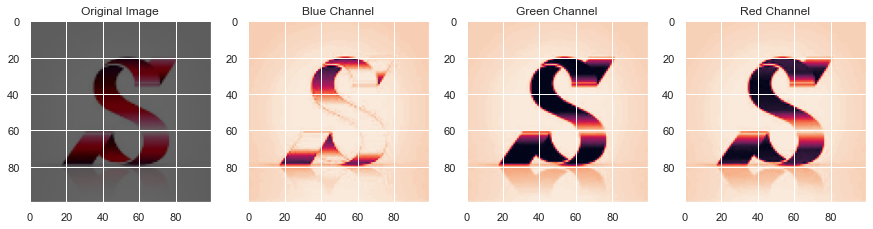

In [25]:
plot_img_decomposition(1306)

In [26]:
data_w_pca10,red_pca_expvar10,green_pca_expvar10,blue_pca_expvar10,a,b,c = apply_pca(data_complete, n_components=10)
data_w_pca30,red_pca_expvar30,green_pca_expvar30,blue_pca_expvar30,d,e,f = apply_pca(data_complete, n_components=30)
data_w_pca20,red_pca_expvar20,green_pca_expvar20,blue_pca_expvar20,pca_red,pca_green,pca_blue = apply_pca(data_complete, n_components=20)

/Users/agustinferreira/Desktop/finalproyect-stats/env-stats/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/agustinferreira/Desktop/finalproyect-stats/env-stats/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/agustinferreira/Desktop/finalproyect-stats/env-stats/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/agustinferreira/Desktop/finalproyect-stats/env-stats/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/agustinferreira/Desktop/f

In [27]:
var_dict={'red_pca_expvar10':red_pca_expvar10, 'green_pca_expvar10':green_pca_expvar10, 'blue_pca_expvar10':blue_pca_expvar10, 
'red_pca_expvar20':red_pca_expvar20,'green_pca_expvar20':green_pca_expvar20,'blue_pca_expvar20':blue_pca_expvar20,
'red_pca_expvar30':red_pca_expvar30,'green_pca_expvar30':green_pca_expvar30,'blue_pca_expvar30':blue_pca_expvar30}

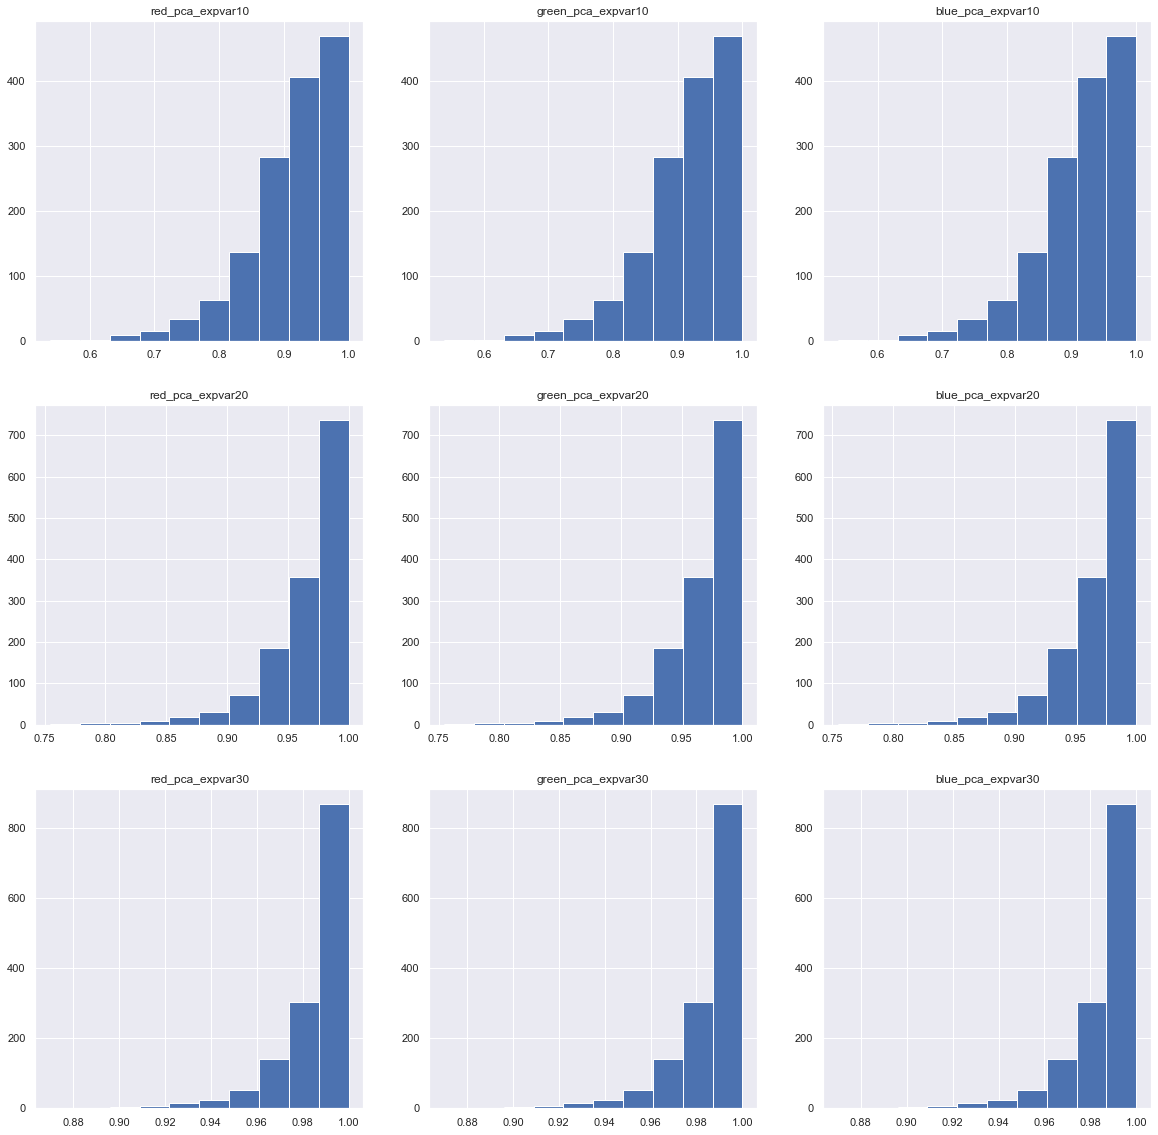

In [28]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(20,20)
for i in range(3):
    for j,color in enumerate(['red','green','blue']):
        plot = (i+1)*10
        aux=f'{color}_pca_expvar{plot}'
        axs[i, j].hist(pd.Series(var_dict.get(aux)))
        axs[i, j].set_title(aux)

In [29]:
b_arr = pca_blue.inverse_transform(data_w_pca20['blue_channel_PCA'][1424])
g_arr = pca_green.inverse_transform(data_w_pca20['green_channel_PCA'][1424])
r_arr = pca_red.inverse_transform(data_w_pca20['red_channel_PCA'][1424])

img_reduced= (cv2.merge((b_arr, g_arr, r_arr)))
print(img_reduced.shape)

(100, 100, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


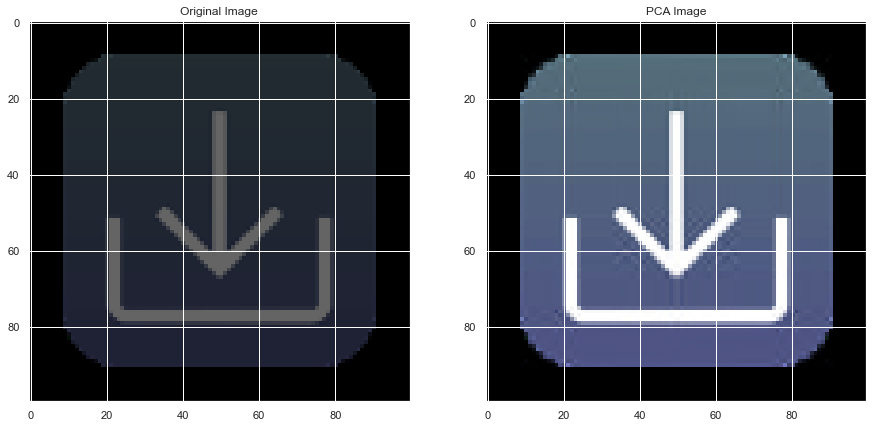

In [30]:
plot_pca(1424)

In [31]:
data_w_pca20.head()

,Rating,Rating Count,Maximum Installs,Price,size_norm,version,time_realise,time_updated,time_realise_update,Category_Adventure,Category_Arcade,Category_Art & Design,Category_Auto & Vehicles,Category_Beauty,Category_Board,Category_Books & Reference,Category_Business,Category_Card,Category_Casino,Category_Casual,Category_Comics,Category_Communication,Category_Dating,Category_Education,Category_Educational,Category_Entertainment,Category_Finance,Category_Food & Drink,Category_Health & Fitness,Category_House & Home,Category_Libraries & Demo,Category_Lifestyle,Category_Maps & Navigation,Category_Medical,Category_Music,Category_Music & Audio,Category_News & Magazines,Category_Parenting,Category_Personalization,Category_Photography,Category_Productivity,Category_Puzzle,Category_Racing,Category_Role Playing,Category_Shopping,Category_Simulation,Category_Social,Category_Sports,Category_Strategy,Category_Tools,Category_Travel & Local,Category_Trivia,Category_Video Players & Editors,Category_Weather,Category_Word,Free_True,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Ad Supported_True,In App Purchases_True,Editors Choice_True,Big_Category2_Education,Big_Category2_Entertainment,Big_Category2_Games,Big_Category2_Lifestyle,Big_Category2_Tools,App Name,App,original_image,blue_channel,green_channel,red_channel,red_channel_scaled,blue_channel_scaled,green_channel_scaled,blue_channel_PCA,green_channel_PCA,red_channel_PCA
0,3.70000,1515.00000,312649.00000,0.00000,24.00000,5.00000,1842.00000,2.00000,1840.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,Flexiroam X,Flexiroam X,"[[[87, 15, 15], [87, 15, 15], [87, 15, 15], [8...","[[87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, ...","[[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, ...","[[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, ...","[[0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0....","[[0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0....","[[0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0....","[[-0.45353165170226384, 0.5103672124898899, -0...","[[4.7512781630518734, 1.554871348268236, -1.30...","[[4.7512781630518734, 1.554871348268236, -1.30..."
1,4.30000,27931.00000,1846446.00000,0.00000,118.00000,5.00000,555.00000,14.00000,541.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,Play To Win: Win Real Money in Cash Sweepstakes,Play To Win: Win Real Money in Cash Sweepstakes,"[[[97, 72, 17], [99, 73, 18], [99, 71, 13], [9...","[[97, 99, 99, 99, 100, 100, 100, 100, 100, 99,...","[[72, 73, 71, 70, 71, 70, 70, 69, 69, 69, 68, ...","[[17, 18, 13, 15, 16, 15, 15, 15, 15, 13, 13, ...","[[0.17, 0.18, 0.13, 0.15, 0.16, 0.15, 0.15, 0....","[[0.97, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, ...","[[0.72, 0.73, 0.71, 0.7, 0.71, 0.7, 0.7, 0.69,...","[[-2.3843535861050227, -0.7240294530929751, 0....","[[-0.008333901048839343, 0.25064153873683076, ...","[[3.035646257606323, 2.2483177561825345, -0.54..."
2,4.70000,1467.00000,155423.00000,0.00000,3.40000,4.10000,548.00000,252.00000,296.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00

In [32]:
for i in range(data_w_pca20.shape[0]):
    if i ==0:
        dfblue = pd.DataFrame([data_w_pca20['blue_channel_PCA'][i].ravel()])
    else:
        dfblue = dfblue.append(pd.DataFrame([data_w_pca20['blue_channel_PCA'][i].ravel()]))
dfblue.columns = [f'b{i}' for i in dfblue.columns]

for i in range(data_w_pca20.shape[0]):
    if i ==0:
        dfred = pd.DataFrame([data_w_pca20['red_channel_PCA'][i].ravel()])
    else:
        dfred = dfred.append(pd.DataFrame([data_w_pca20['red_channel_PCA'][i].ravel()]))
dfred.columns = [f'r{i}' for i in dfred.columns]

for i in range(data_w_pca20.shape[0]):
    if i ==0:
        dfgreen = pd.DataFrame([data_w_pca20['green_channel_PCA'][i].ravel()])
    else:
        dfgreen = dfgreen.append(pd.DataFrame([data_w_pca20['green_channel_PCA'][i].ravel()]))
dfgreen.columns = [f'g{i}' for i in dfgreen.columns]

In [33]:
df_total = pd.concat([dfgreen,dfblue,dfred],axis=1)
df_total.reset_index(inplace=True, drop = True)

In [34]:
### Train a K means Segmentation 
from sklearn.cluster import KMeans
K = range(1,20,2)
distortions = []
for k in K:
    k_means=KMeans(n_clusters=k,init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=42, copy_x=True, algorithm='auto')
    k_means.fit(df_total)
    distortions.append(k_means.inertia_)
df_total['Cluster'] = k_means.predict(df_total)


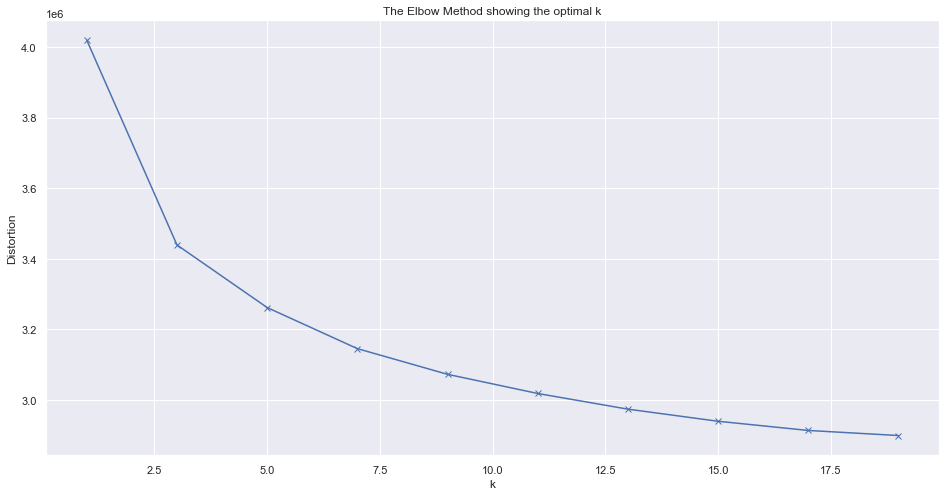

In [35]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [36]:
k_means_4=KMeans(n_clusters=18,init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=42, copy_x=True, algorithm='auto')
k_means_4.fit(df_total)
df_total['Cluster'] = k_means_4.predict(df_total)


In [37]:
df_total['Cluster'].value_counts()

6     145
7     131
8     119
14    116
11    106
3     101
15     96
5      89
2      82
4      75
9      66
13     59
17     54
10     52
1      42
16     35
0      30
12     27
Name: Cluster, dtype: int64

In [38]:
df_total['Cluster'].value_counts()
images_print = {}
for i in df_total['Cluster'].value_counts().index:
     images_print[i]= df_total[df_total['Cluster']==i].sample(5, random_state=1234).index.tolist()

In [39]:
df_total['Cluster'].value_counts()

6     145
7     131
8     119
14    116
11    106
3     101
15     96
5      89
2      82
4      75
9      66
13     59
17     54
10     52
1      42
16     35
0      30
12     27
Name: Cluster, dtype: int64

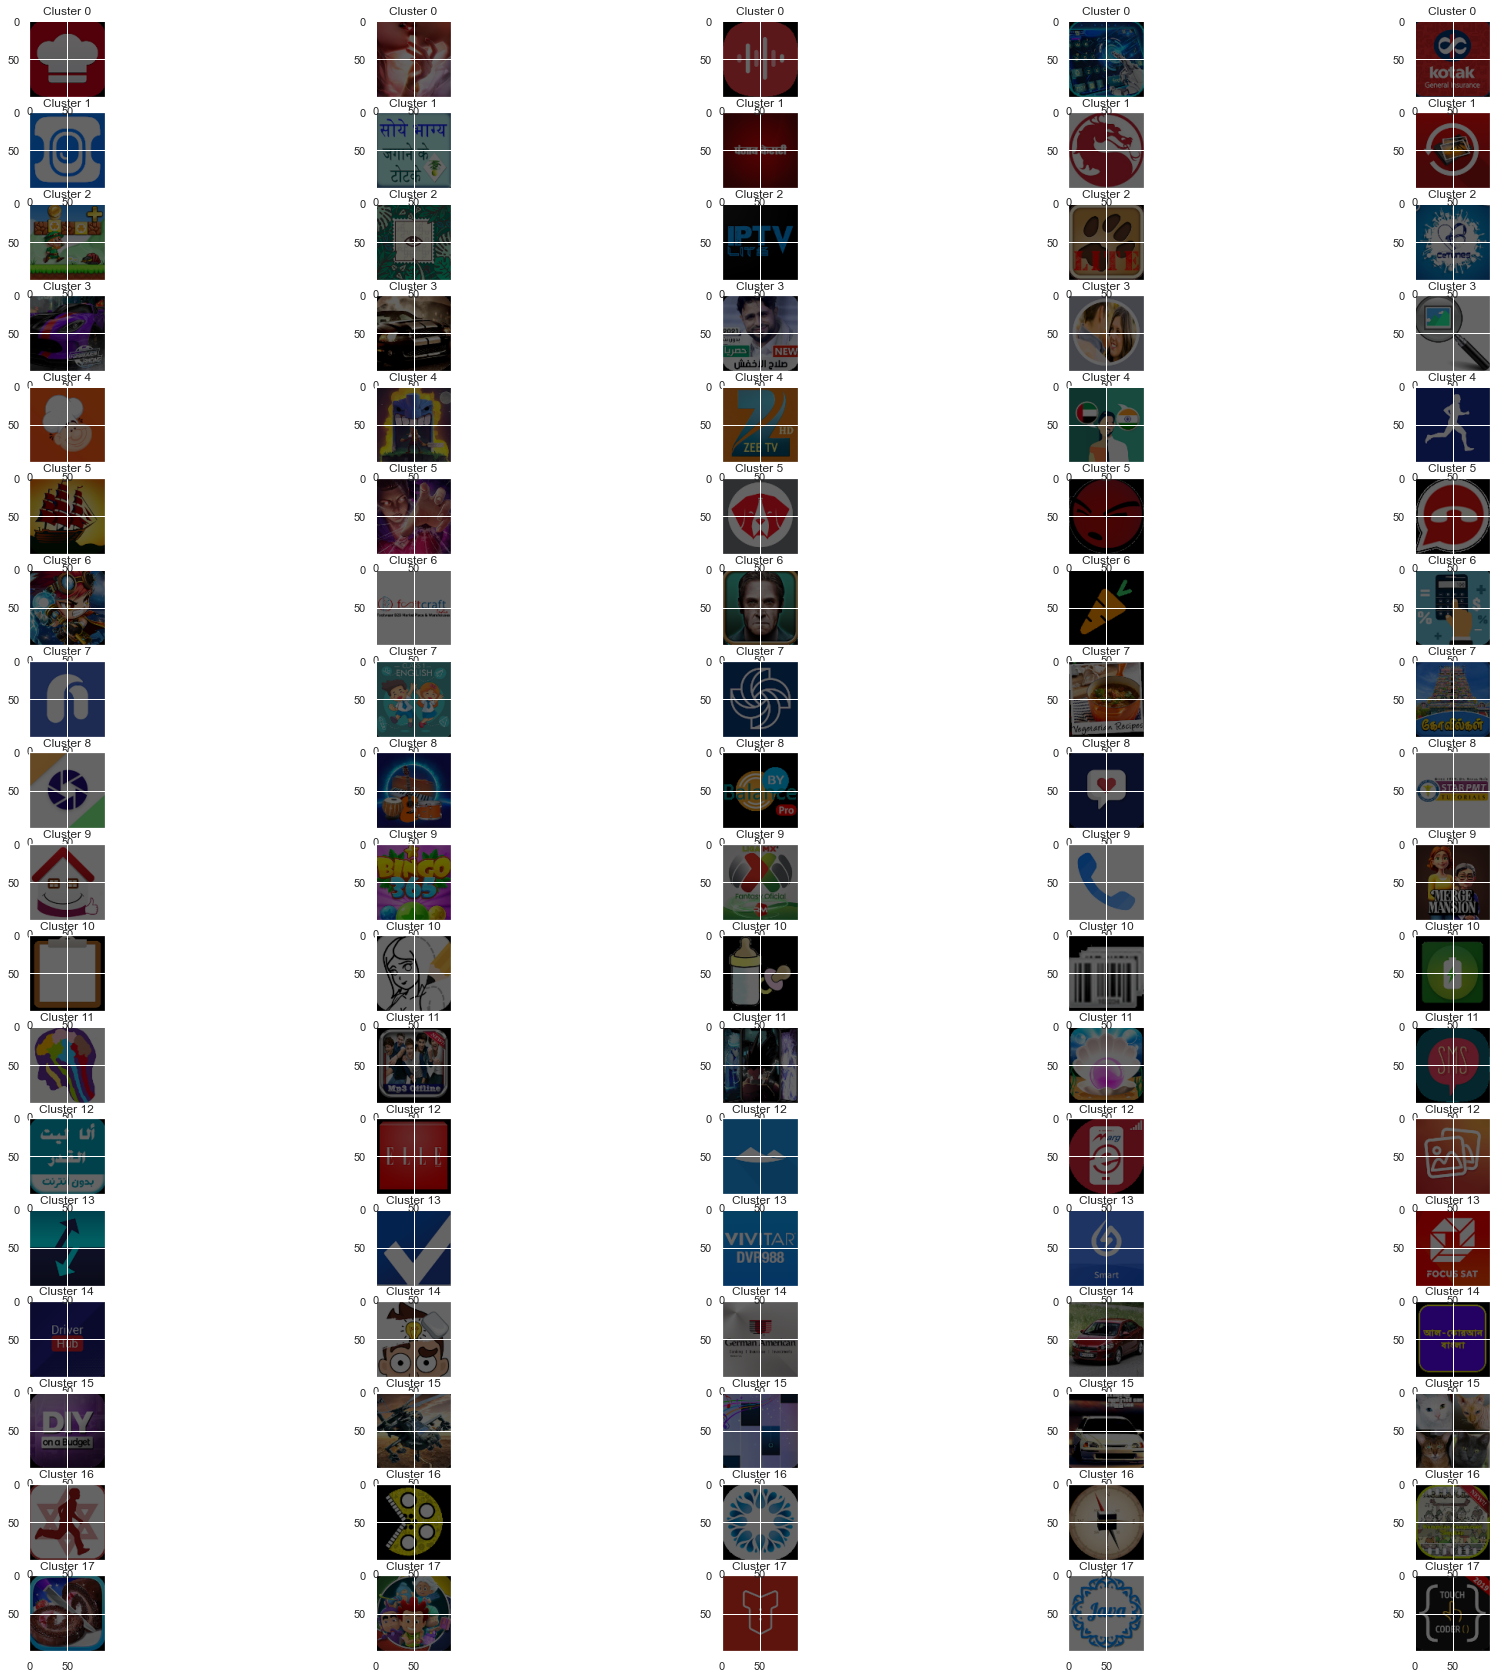

In [40]:
fig = plt.figure(figsize = (30, 30))
plt.subplot()
count=1
for i,j in images_print.items():
        for k,z in enumerate(j):
            aux_var=int(str(4)+str(5)+str(count))
            count=count+1
            plt.subplot2grid((18,5), (i,k))
            #fig.add_subplot(aux_var)
            plt.title(f'Cluster {i}')
            plt.imshow(Image.fromarray(data_complete.iloc[z,69]))

In [41]:
data_w_pca20['cluster']=df_total['Cluster']

In [42]:
table=data_w_pca20.pivot_table(index='cluster',values=['Big_Category2_Education','Big_Category2_Entertainment', 'Big_Category2_Games','Big_Category2_Lifestyle', 'Big_Category2_Tools'],aggfunc='sum',margins=True)
toplot_clusters = pd.DataFrame(table/table.iloc[-1,:])

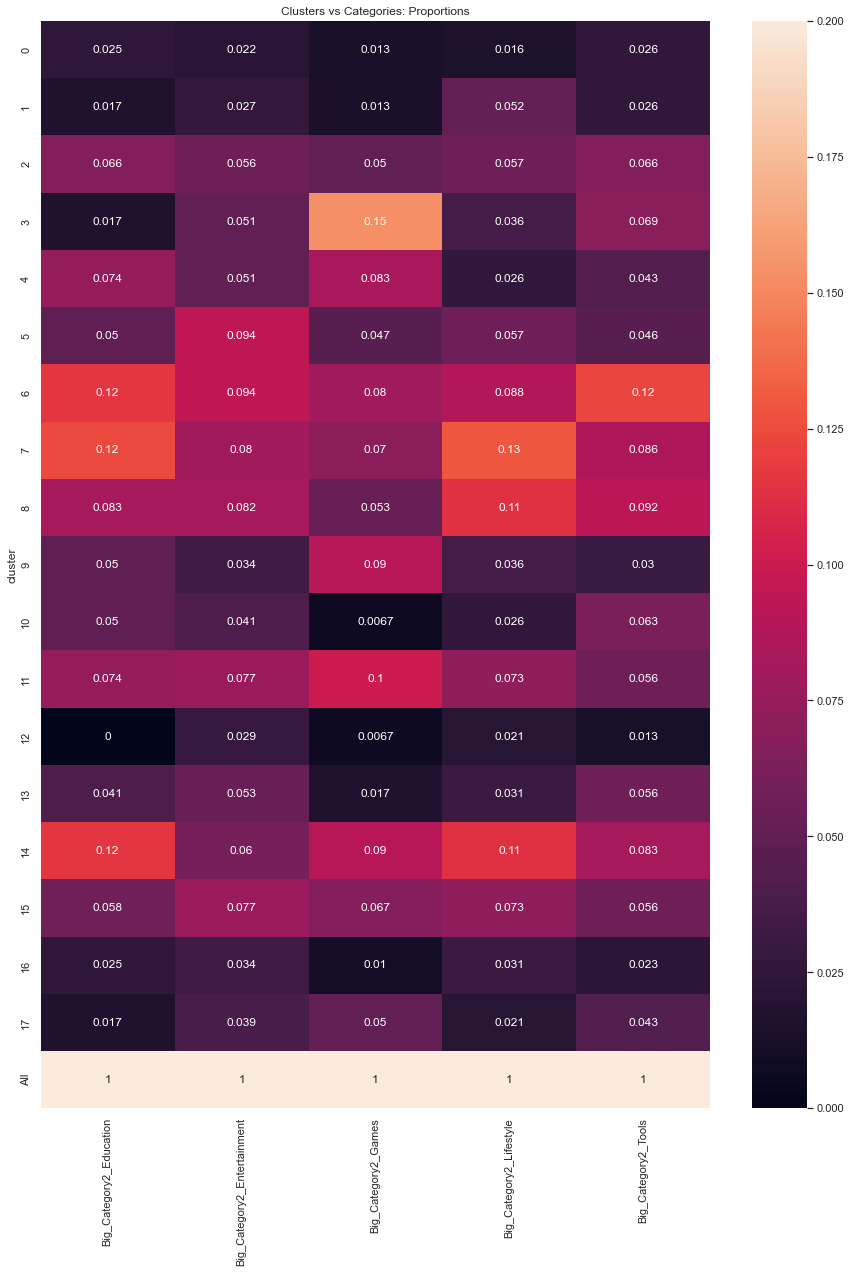

In [43]:
### Existe Algun tipo de correlacion en las variables 

sns.set(rc = {'figure.figsize':(15,20)})
sns.heatmap(toplot_clusters, annot=True, vmin = 0.0, vmax = 0.2)
plt.title('Clusters vs Categories: Proportions')
plt.show()

In [44]:
data_w_pca20.groupby(['cluster']).agg({'Big_Category2_Education':'sum','Big_Category2_Entertainment':'sum', 'Big_Category2_Games':'sum','Big_Category2_Lifestyle':'sum', 'Big_Category2_Tools':'sum'}).reset_index()

,cluster,Big_Category2_Education,Big_Category2_Entertainment,Big_Category2_Games,Big_Category2_Lifestyle,Big_Category2_Tools
0,0,3.00000,9.00000,4.00000,3.00000,8.00000
1,1,2.00000,11.00000,4.00000,10.00000,8.00000
2,2,8.00000,23.00000,15.00000,11.00000,20.00000
3,3,2.00000,21.00000,46.00000,7.00000,21.00000
4,4,9.00000,21.00000,25.00000,5.00000,13.00000
5,5,6.00000,39.00000,14.00000,11.00000,14.00000
6,6,14.00000,39.00000,24.00000,17.00000,37.00000
7,7,15.00000,33.00000,21.00000,25.00000,26.00000
8,8,10.00000,34.00000,16.00000,22.00000,28.00000
9,9,6.00000,14.00000,27.00000,7.00000,9.00000


In [45]:
data_w_pca20['big_category_2']=['Education' if i ==1 else 'Entertaiment' if j==1 else 'Games' if k==1 else 'Lifestyle' if l==1 else 'Tools' if m==1 else 'Business' for i,j,k,l,m in zip(data_w_pca20['Big_Category2_Education'],data_w_pca20['Big_Category2_Entertainment'], data_w_pca20['Big_Category2_Games'],data_w_pca20['Big_Category2_Lifestyle'], data_w_pca20['Big_Category2_Tools'])]

In [46]:
data_w_pca20['big_category_2'].value_counts()

Entertaiment    414
Tools           303
Games           300
Lifestyle       193
Education       121
Business         94
Name: big_category_2, dtype: int64

In [47]:
table_1=data_w_pca20.pivot_table(index='cluster',values=['Rating'],aggfunc='mean',margins=True)

In [48]:
data_w_pca20.columns
data_w_pca20['avg_rating']=[i/j for i,j in zip(data_w_pca20['Rating'],data_w_pca20['Rating Count'])]

<AxesSubplot:>

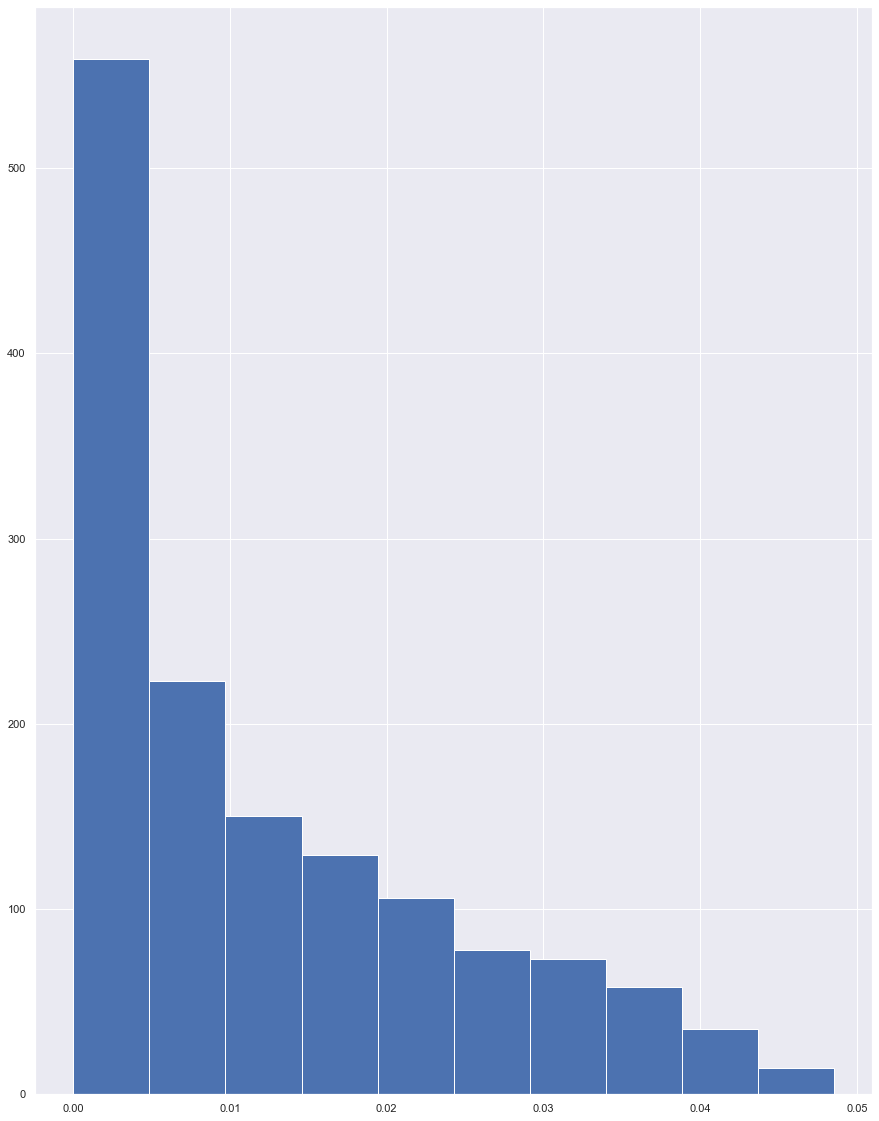

In [49]:
data_w_pca20['avg_rating'].hist()

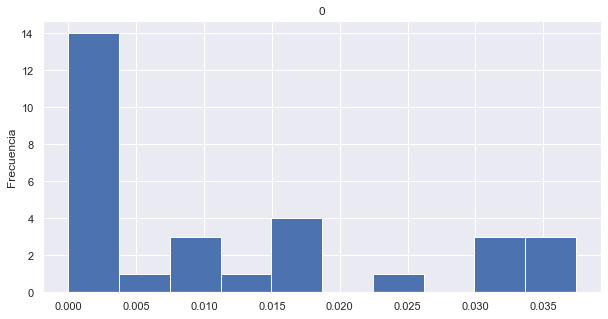

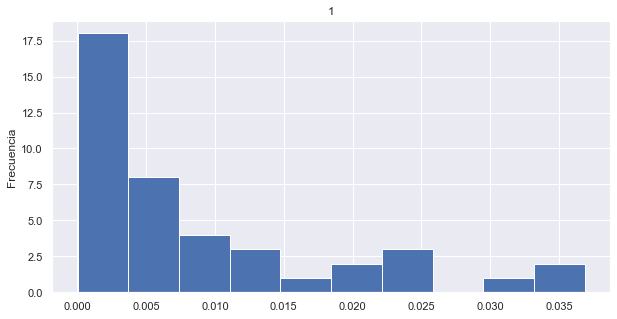

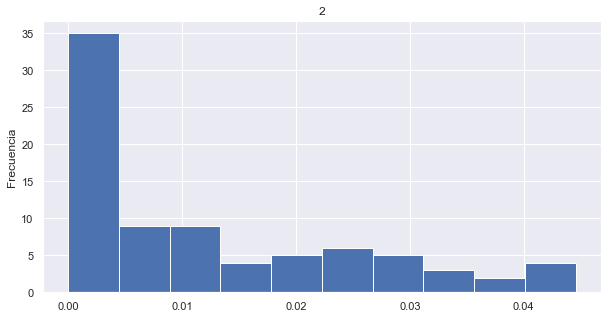

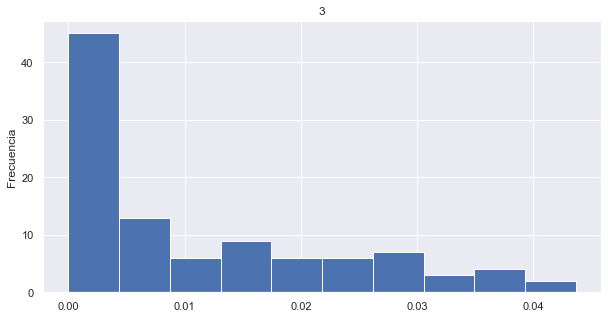

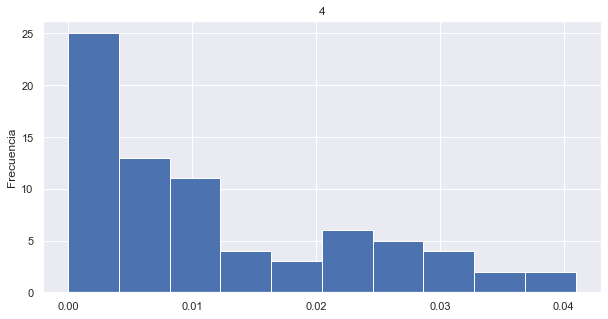

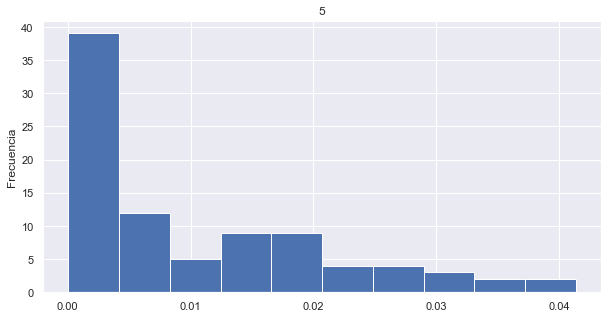

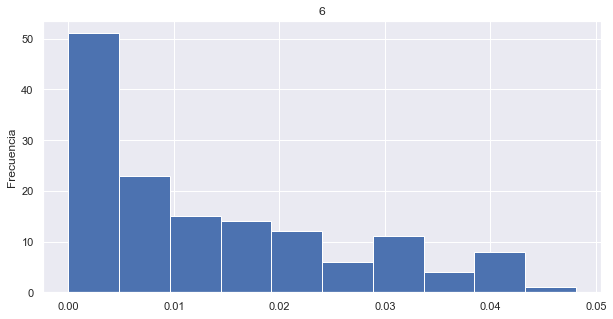

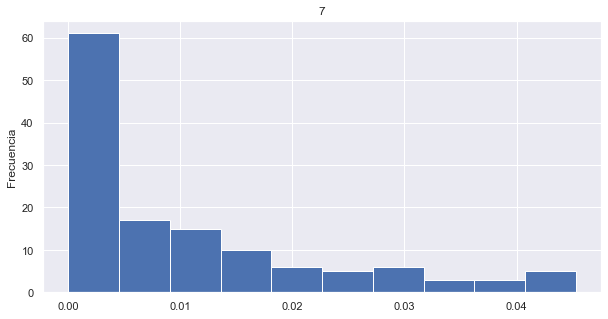

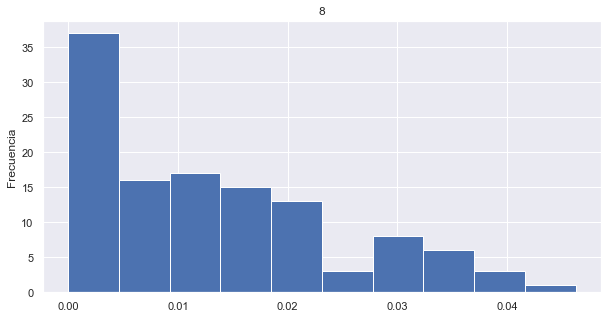

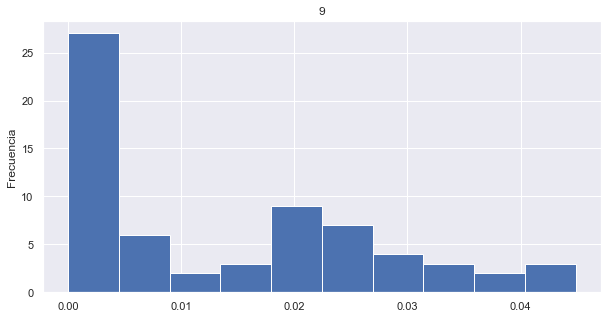

In [50]:
for i in range(10):
    sns.set(rc = {'figure.figsize':(10,5)})
    data_w_pca20[data_w_pca20['cluster']==i]['avg_rating'].hist()
    plt.title(i)
    plt.ylabel('Frecuencia')
    plt.show()
    plt.show()

In [51]:
data_train = data_w_pca20.drop(['App Name', 'App',
       'original_image', 'blue_channel', 'green_channel', 'red_channel',
       'red_channel_scaled', 'blue_channel_scaled', 'green_channel_scaled',
       'blue_channel_PCA', 'green_channel_PCA', 'red_channel_PCA',
       'big_category_2', 'avg_rating','cluster','Rating','Rating Count'], axis = 1)

In [52]:
data_train = pd.concat([data_train,df_total], axis = 1)

In [53]:
data_train = pd.get_dummies(data_train, prefix=['Cluster'], columns=['Cluster'], drop_first = True)

In [54]:
### Drop Pixel Variables 
data_train_1=data_train.drop(['g'+str(i) for i in range(0,2000)],axis=1)
data_train_1=data_train_1.drop(['b'+str(i) for i in range(0,2000)],axis=1)
data_train_1=data_train_1.drop(['r'+str(i) for i in range(0,2000)],axis=1)
data_train_1.head()

,Maximum Installs,Price,size_norm,version,time_realise,time_updated,time_realise_update,Category_Adventure,Category_Arcade,Category_Art & Design,Category_Auto & Vehicles,Category_Beauty,Category_Board,Category_Books & Reference,Category_Business,Category_Card,Category_Casino,Category_Casual,Category_Comics,Category_Communication,Category_Dating,Category_Education,Category_Educational,Category_Entertainment,Category_Finance,Category_Food & Drink,Category_Health & Fitness,Category_House & Home,Category_Libraries & Demo,Category_Lifestyle,Category_Maps & Navigation,Category_Medical,Category_Music,Category_Music & Audio,Category_News & Magazines,Category_Parenting,Category_Personalization,Category_Photography,Category_Productivity,Category_Puzzle,Category_Racing,Category_Role Playing,Category_Shopping,Category_Simulation,Category_Social,Category_Sports,Category_Strategy,Category_Tools,Category_Travel & Local,Category_Trivia,Category_Video Players & Editors,Category_Weather,Category_Word,Free_True,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Ad Supported_True,In App Purchases_True,Editors Choice_True,Big_Category2_Education,Big_Category2_Entertainment,Big_Category2_Games,Big_Category2_Lifestyle,Big_Category2_Tools,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17
0,312649.00000,0.00000,24.00000,5.00000,1842.00000,2.00000,1840.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1846446.00000,0.00000,118.00000,5.00000,555.00000,14.00000,541.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,155423.00000,0.00000,3.40000,4.10000,548.00000,252.00000,296.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,36807.00000,0.00000,12.00000,4.20000,637.00000,298.00000,339.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,76328.00000,0.00000,11.00000,4.40000,878.00000,664.00000,214.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,

In [55]:
### Without images
data_train_original=data_train_1.drop(['Cluster_1','Cluster_2','Cluster_3','Cluster_4','Cluster_5','Cluster_6','Cluster_7','Cluster_8','Cluster_9','Cluster_10','Cluster_11','Cluster_12','Cluster_13','Cluster_14','Cluster_15','Cluster_16','Cluster_17'],axis=1)

In [56]:
data_train_original.head()

,Maximum Installs,Price,size_norm,version,time_realise,time_updated,time_realise_update,Category_Adventure,Category_Arcade,Category_Art & Design,Category_Auto & Vehicles,Category_Beauty,Category_Board,Category_Books & Reference,Category_Business,Category_Card,Category_Casino,Category_Casual,Category_Comics,Category_Communication,Category_Dating,Category_Education,Category_Educational,Category_Entertainment,Category_Finance,Category_Food & Drink,Category_Health & Fitness,Category_House & Home,Category_Libraries & Demo,Category_Lifestyle,Category_Maps & Navigation,Category_Medical,Category_Music,Category_Music & Audio,Category_News & Magazines,Category_Parenting,Category_Personalization,Category_Photography,Category_Productivity,Category_Puzzle,Category_Racing,Category_Role Playing,Category_Shopping,Category_Simulation,Category_Social,Category_Sports,Category_Strategy,Category_Tools,Category_Travel & Local,Category_Trivia,Category_Video Players & Editors,Category_Weather,Category_Word,Free_True,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Ad Supported_True,In App Purchases_True,Editors Choice_True,Big_Category2_Education,Big_Category2_Entertainment,Big_Category2_Games,Big_Category2_Lifestyle,Big_Category2_Tools
0,312649.00000,0.00000,24.00000,5.00000,1842.00000,2.00000,1840.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
1,1846446.00000,0.00000,118.00000,5.00000,555.00000,14.00000,541.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
2,155423.00000,0.00000,3.40000,4.10000,548.00000,252.00000,296.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
3,36807.00000,0.00000,12.00000,4.20000,637.00000,298.00000,339.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
4,76328.00000,0.00000,11.00000,4.40000,878.00000,664.00000,214.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000


In [57]:

X_train_original = data_train_original.drop('Maximum Installs', axis = 1)
y_train_original = data_train_original['Maximum Installs']
y_train_1_original=pd.DataFrame()
y_train_1_original['Maximum Installs']=[1 if i>=86534 else 0 for i in y_train_original]

In [58]:
# Create the interactions 
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_train_1_original=pd.DataFrame(poly.fit_transform(X_train_original),columns=poly.get_feature_names(X_train_original.columns))

In [59]:
y_train_1_original.shape

(1425, 1)

In [60]:
a_original,b_original=selection(X_train_1_original,y_train_1_original,0.4)

/Users/agustinferreira/Desktop/finalproyect-stats/env-stats/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


aca


In [61]:
### New Data Without Correlation 
new_data_original=X_train_1_original[b_original.nombres]
new_data_original.shape

(1425, 1504)

In [62]:
#L1 with PCAx3-Kmeans and correlated variable selection

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from math import comb

model_1_auc=[]
model_1_bic=[]
model_1_variables=[]
for i in range(5,100,10):
    ### Cross Validation 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    lst_accu_stratified = []
    lst_bic_stratified = []
    lst_ebic_stratified = []
    log=LogisticRegression(C=(i/100), penalty='l1',solver='liblinear')
    scaler = StandardScaler() 
    scaler.fit(new_data_original.fillna(0))
    X_scaled=pd.DataFrame(scaler.transform(new_data_original))
    X_scaled.columns=new_data_original.columns
    for train_index, test_index in skf.split(new_data_original, y_train_1_original):
        x_train_fold, x_test_fold = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train_fold, y_test_fold = y_train_1_original.iloc[train_index], y_train_1_original.iloc[test_index]

        log.fit(x_train_fold, y_train_fold['Maximum Installs'])
        predict_test=log.predict_proba(x_test_fold)[:,1]
        lst_accu_stratified.append(roc_auc_score(y_test_fold,predict_test))
        lst_bic_stratified.append(-2*sum(predict_test)+(np.log(len(y_train_fold['Maximum Installs']))*sum(log.coef_[0]!=0)))

    print('Lambda: '+str(i/100))
    print('Coef !=0 '+str(sum(log.coef_[0]!=0)))
    model_1_variables.append(sum(log.coef_[0]!=0))
    print(x_train_fold.columns[log.coef_[0]!=0])
    print('CV BIC: '+str(np.mean(lst_bic_stratified)))
    model_1_bic.append(np.mean(lst_bic_stratified))
    print('CV AUC:' +str(np.mean(lst_accu_stratified)))
    model_1_auc.append(np.mean(lst_accu_stratified))

Lambda: 0.05
Coef !=0 31
Index(['Free_True Content Rating_Mature 17+',
       'time_realise_update Ad Supported_True',
       'Free_True Big_Category2_Games', 'Category_Books & Reference Free_True',
       'In App Purchases_True Big_Category2_Tools',
       'size_norm time_realise_update', 'time_realise Category_Role Playing',
       'version Category_Education', 'version time_updated',
       'Price time_realise', 'time_realise Category_Music',
       'Category_Simulation Free_True', 'Category_Beauty Ad Supported_True',
       'Category_Photography', 'Category_Sports In App Purchases_True',
       'time_realise_update Big_Category2_Tools',
       'Category_Books & Reference In App Purchases_True',
       'Category_Arcade Free_True',
       'Category_Social Content Rating_Mature 17+',
       'Category_Video Players & Editors Free_True',
       'Category_Personalization Ad Supported_True',
       'Content Rating_Teen Big_Category2_Education',
       'time_updated Category_Medical',
    

In [63]:
model_l1=pd.DataFrame()
model_l1['lambda']=[100-i for i in range(5,100,10)]
model_l1['model_1_l1_auc']=model_1_auc
model_l1['model_1_l1_bic']=model_1_bic
model_l1['model_1_l1_var']=model_1_variables
model_l1.head()

,lambda,model_1_l1_auc,model_1_l1_bic,model_1_l1_var
0,95,0.69399,-59.35380,31
1,85,0.68330,308.00247,87
2,75,0.67779,391.88165,98
3,65,0.67509,430.83829,107
4,55,0.67319,443.24600,108


In [64]:
X_train = data_train_1.drop('Maximum Installs', axis = 1)
y_train = data_train_1['Maximum Installs']
y_train_1=pd.DataFrame()
y_train_1['Maximum Installs']=[1 if i>=86534 else 0 for i in y_train]

In [65]:
# Create the interactions 
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_train_1=pd.DataFrame(poly.fit_transform(X_train),columns=poly.get_feature_names(X_train.columns))

In [66]:
a,b=selection(X_train_1,y_train_1,0.4)

/Users/agustinferreira/Desktop/finalproyect-stats/env-stats/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


aca


In [67]:
### New Data Without Correlation 
new_data=X_train_1[b.nombres]
new_data.shape

(1425, 2248)

In [68]:
#L1 with PCAx3-Kmeans and correlated variable selection

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from math import comb
model_2_auc=[]
model_2_bic=[]
model_2_variables=[]

for i in range(5,100,10):
    ### Cross Validation 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    lst_accu_stratified = []
    lst_bic_stratified = []
    lst_ebic_stratified = []
    log=LogisticRegression(C=(i/100), penalty='l1',solver='liblinear')
    scaler = StandardScaler() 
    scaler.fit(new_data.fillna(0))
    X_scaled=pd.DataFrame(scaler.transform(new_data))
    X_scaled.columns=new_data.columns
    for train_index, test_index in skf.split(new_data, y_train_1):
        x_train_fold, x_test_fold = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train_fold, y_test_fold = y_train_1.iloc[train_index], y_train_1.iloc[test_index]

        log.fit(x_train_fold, y_train_fold['Maximum Installs'])
        predict_test=log.predict_proba(x_test_fold)[:,1]
        lst_accu_stratified.append(roc_auc_score(y_test_fold,predict_test))
        lst_bic_stratified.append(-2*sum(predict_test)+(np.log(len(y_train_fold['Maximum Installs']))*sum(log.coef_[0]!=0)))

    print('Lambda: '+str(i/100))
    print('Coef !=0 '+str(sum(log.coef_[0]!=0)))
    model_2_variables.append(sum(log.coef_[0]!=0))
    print(x_train_fold.columns[log.coef_[0]!=0])
    print('CV BIC: '+str(np.mean(lst_bic_stratified)))
    model_2_bic.append(np.mean(lst_bic_stratified))
    print('CV AUC:' +str(np.mean(lst_accu_stratified)))
    model_2_auc.append(np.mean(lst_accu_stratified))

Lambda: 0.05
Coef !=0 84
Index(['time_realise_update Ad Supported_True',
       'size_norm Big_Category2_Games', 'size_norm time_realise_update',
       'Category_Music & Audio Big_Category2_Entertainment',
       'version time_updated', 'Category_Productivity Cluster_6',
       'version Category_Education', 'Free_True Big_Category2_Tools',
       'Category_Entertainment Cluster_14', 'version Category_Role Playing',
       'Category_Medical Cluster_7', 'Category_Finance Cluster_15',
       'Content Rating_Mature 17+ In App Purchases_True',
       'time_realise Cluster_3', 'time_realise_update In App Purchases_True',
       'size_norm Category_Personalization', 'Category_Photography',
       'Category_Adventure Cluster_11', 'Category_Tools Cluster_2',
       'Category_Adventure Cluster_3', 'Ad Supported_True Cluster_12',
       'Content Rating_Mature 17+ Cluster_12', 'time_updated Category_Tools',
       'Category_Education Cluster_4', 'Category_Dating Cluster_8',
       'Category_Socia

log=LogisticRegression(C=(0.05), penalty='l1',solver='liblinear')
scaler = StandardScaler() 
scaler.fit(new_data.fillna(0))
X_scaled=pd.DataFrame(scaler.transform(new_data))
X_scaled.columns=new_data.columns
log.fit(X_scaled, y_train_1['Maximum Installs'])
X_scaled.columns[log.coef_[0]!=0]

In [69]:
model2_l1=pd.DataFrame()
model2_l1['lambda']=[100-i for i in range(5,100,10)]
model2_l1['model_2_l1_auc']=model_2_auc
model2_l1['model_2_l1_bic']=model_2_bic
model2_l1['model_2_l1_var']=model_2_variables
model2_l1.head()

,lambda,model_2_l1_auc,model_2_l1_bic,model_2_l1_var
0,95,0.68783,372.18181,84
1,85,0.65294,1692.55079,283
2,75,0.64036,1931.80391,319
3,65,0.63488,2021.97866,335
4,55,0.63127,2079.57179,341


In [70]:
a.head()

,index,nombres,scores
0,521,time_realise_update Ad Supported_True,0.05781
1,2119,Category_Music Content Rating_Teen,0.05375
2,2918,Free_True Ad Supported_True,0.05214
3,1041,Category_Books & Reference Cluster_16,0.05032
4,220,size_norm Big_Category2_Games,0.04680


In [83]:
log=LogisticRegression(C=(0.05), penalty='l1',solver='liblinear')
scaler = StandardScaler() 
scaler.fit(new_data.fillna(0))
X_scaled=pd.DataFrame(scaler.transform(new_data))
X_scaled.columns=new_data.columns
log.fit(x_train_fold, y_train_fold['Maximum Installs'])
aux=pd.DataFrame()
aux['most_important_variables']=X_scaled.columns[log.coef_[0]!=0]
aux_1=aux.merge(a,left_on='most_important_variables',right_on='nombres')
aux_1.head()

,most_important_variables,index,nombres,scores
0,time_realise_update Ad Supported_True,521,time_realise_update Ad Supported_True,0.05781
1,size_norm Big_Category2_Games,220,size_norm Big_Category2_Games,0.04680
2,size_norm time_realise_update,164,size_norm time_realise_update,0.04238
3,Category_Music & Audio Big_Category2_Entertain...,2172,Category_Music & Audio Big_Category2_Entertain...,0.03411
4,version time_updated,241,version time_updated,0.03299


In [85]:
#L2 with PCAx3-Kmeans and correlated variable selection

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from math import comb

model_2_auc=[]
model_2_bic=[]


for i in range(5,100,10):
    ### Cross Validation 
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    lst_accu_stratified = []
    lst_bic_stratified = []
    lst_ebic_stratified = []
    log=LogisticRegression(C=(i/100), penalty='l2',solver='liblinear')
    scaler = StandardScaler() 
    scaler.fit(new_data.fillna(0))
    X_scaled=pd.DataFrame(scaler.transform(new_data))
    X_scaled.columns=new_data.columns
    for train_index, test_index in skf.split(new_data, y_train_1):
        x_train_fold, x_test_fold = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train_fold, y_test_fold = y_train_1.iloc[train_index], y_train_1.iloc[test_index]

        log.fit(x_train_fold, y_train_fold['Maximum Installs'])
        predict_test=log.predict_proba(x_test_fold)[:,1]
        lst_accu_stratified.append(roc_auc_score(y_test_fold,predict_test))
        lst_bic_stratified.append(-2*sum(predict_test)+(np.log(len(y_train_fold['Maximum Installs']))*sum(log.coef_[0]!=0)))

    print('Lambda: '+str(i/100))
    print('CV BIC: '+str(np.mean(lst_bic_stratified)))
    model_2_bic.append(np.mean(lst_bic_stratified))
    print('CV AUC:' +str(np.mean(lst_accu_stratified)))
    model_2_auc.append(np.mean(lst_accu_stratified))

Lambda: 0.05
CV BIC: 2737.0227484098223
CV AUC:0.6218433842491569
Lambda: 0.15
CV BIC: 2737.174799805339
CV AUC:0.6160583217615553
Lambda: 0.25
CV BIC: 2737.186832532089
CV AUC:0.6133871696532875
Lambda: 0.35
CV BIC: 2737.1760535926205
CV AUC:0.6119125945028544
Lambda: 0.45
CV BIC: 2737.160418644062
CV AUC:0.6112045118913796
Lambda: 0.55
CV BIC: 2737.1440189187006
CV AUC:0.6108287046220988
Lambda: 0.65
CV BIC: 2737.127848012625
CV AUC:0.6102969538671781
Lambda: 0.75
CV BIC: 2737.1123931487405
CV AUC:0.6102594833476602
Lambda: 0.85
CV BIC: 2737.097849685449
CV AUC:0.6098869823006898
Lambda: 0.95
CV BIC: 2737.0839812880736
CV AUC:0.6100459564901144


In [86]:
model2_l2=pd.DataFrame()
model2_l2['lambda']=[100-i for i in range(5,100,10)]
model2_l2['model_2_l2_auc']=model_2_auc
model2_l2['model_2_l2_bic']=model_2_bic
model2_l2.head()

,lambda,model_2_l2_auc,model_2_l2_bic
0,95,0.62184,2737.02275
1,85,0.61606,2737.17480
2,75,0.61339,2737.18683
3,65,0.61191,2737.17605
4,55,0.61120,2737.16042


In [89]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(i, model):
    # Read image from dataframe
    image = str(i)+str('.png')
    img = load_img(f'/Users/agustinferreira/Desktop/finalproyect-stats/data/images/{image}', target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [90]:
data = {}
error = []
images = data_complete['App']

# lop through each image in the dataset
for i in images:
    # try to extract the features and update the dictionary
    #try:
    feat = extract_features(i,model)
    data[i] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    #except:
        #error.append(i)
          
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape


/Users/agustinferreira/Desktop/finalproyect-stats/env-stats/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(1425, 1, 4096)

In [91]:
#reshape so that there are 1425 samples of 4096 vectors
feat1 = feat.reshape(-1,4096)
feat1.shape

(1425, 4096)

In [92]:
pcafeat = PCA(n_components=1425, random_state=22)
pcafeat.fit(feat1)
feat_pca = pcafeat.transform(feat1)

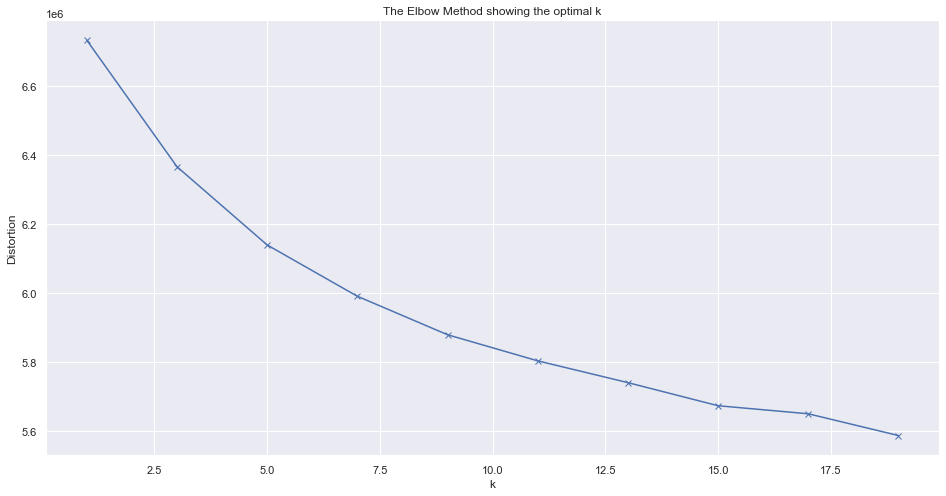

In [93]:
### Train a K means Segmentation 
from sklearn.cluster import KMeans
K = range(1,20,2)
distortions = []
for k in K:
    k_means=KMeans(n_clusters=k,init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=55, copy_x=True, algorithm='auto')
    k_means.fit(feat_pca)
    distortions.append(k_means.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

k_means_feat=KMeans(n_clusters=20,init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=55, copy_x=True, algorithm='auto')
k_means_feat.fit(feat_pca)
df_total['Cluster_NN'] = k_means_feat.predict(feat_pca)


In [94]:
df_total['Cluster_NN'].value_counts()
images_print = {}
for i in df_total['Cluster_NN'].value_counts().index:
     images_print[i]= df_total[df_total['Cluster_NN']==i].sample(5, random_state=1234).index.tolist()

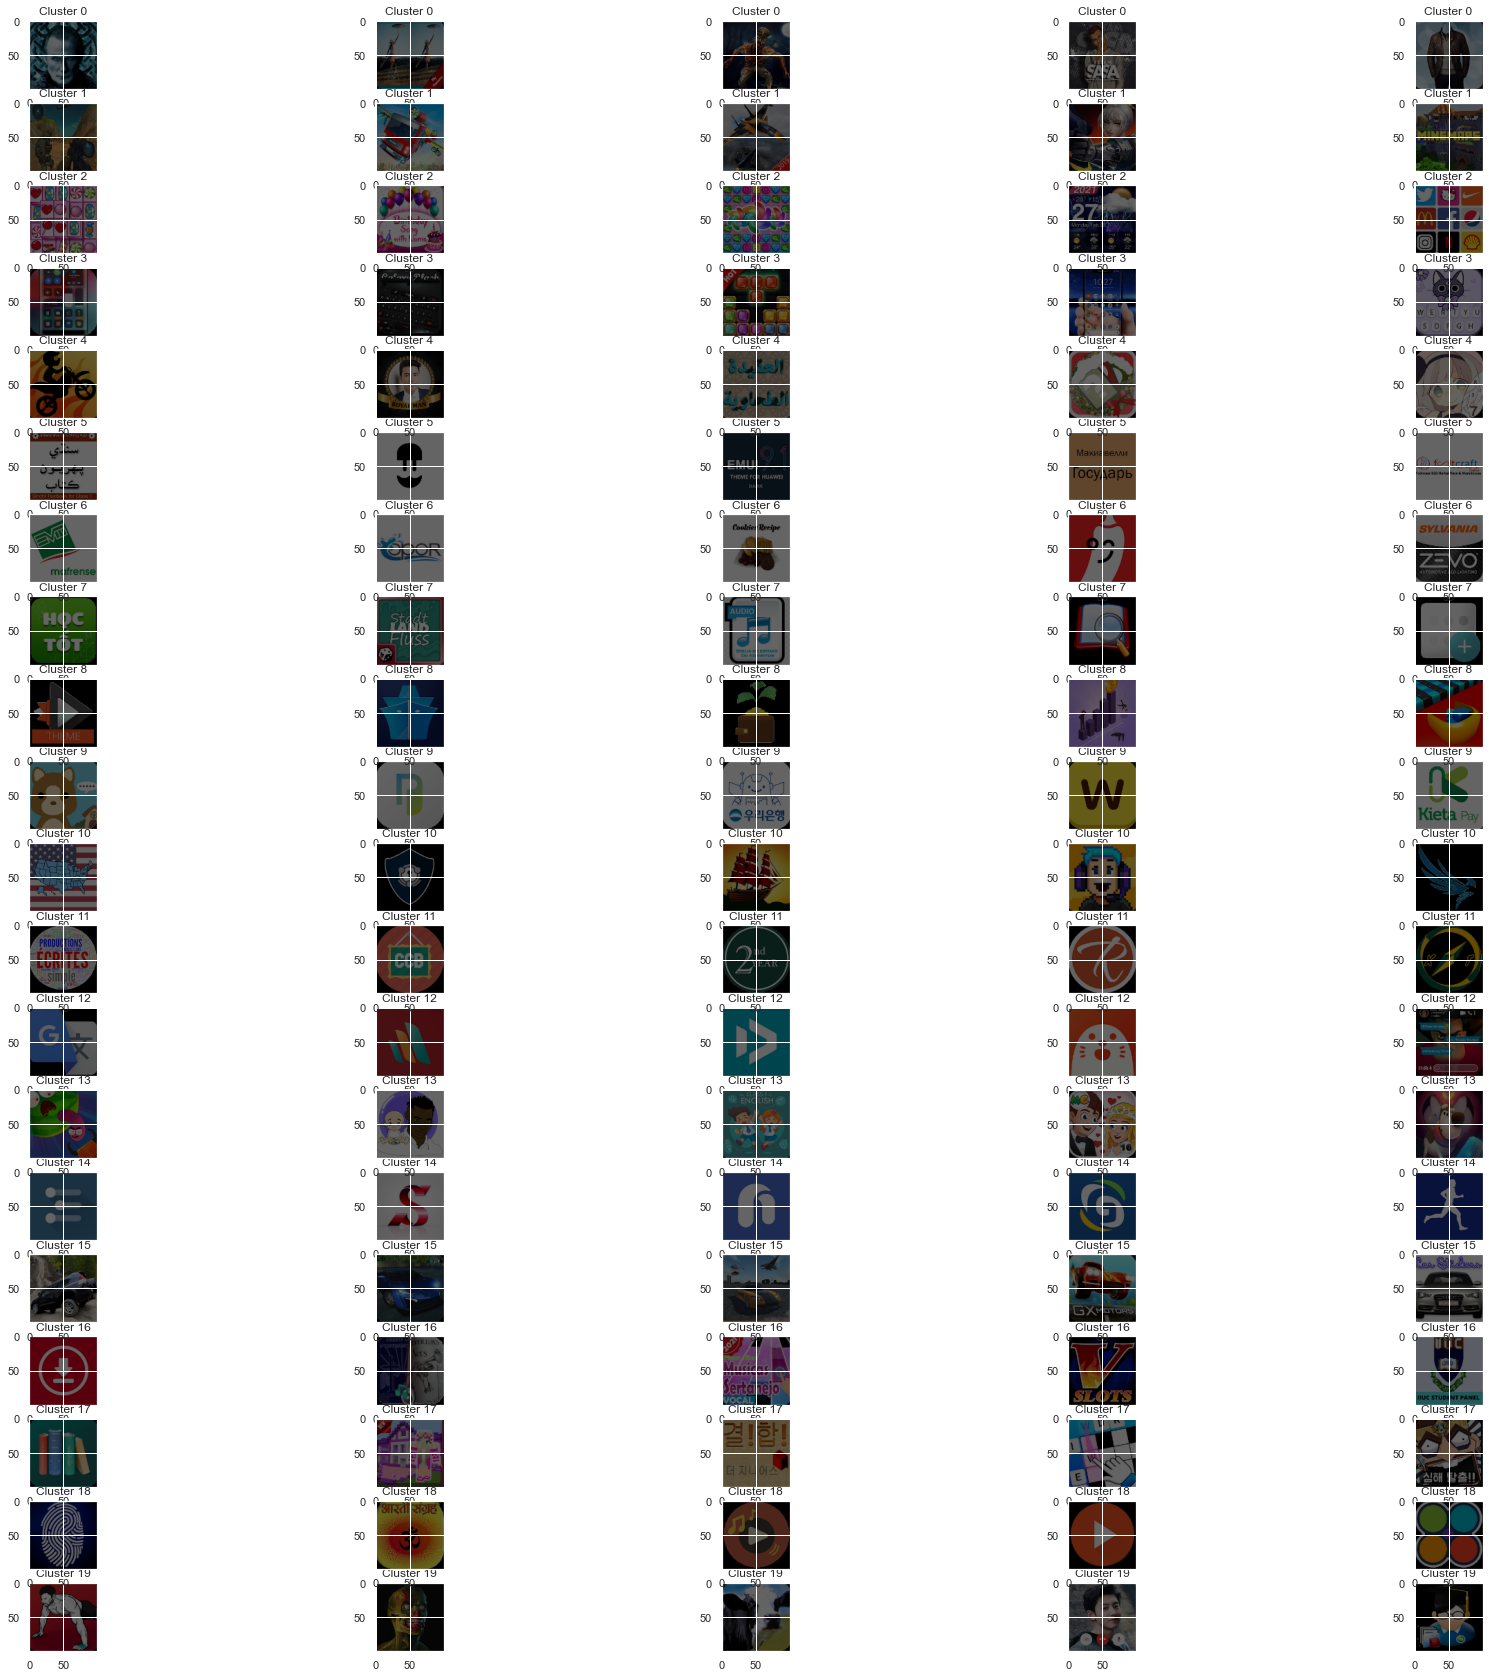

In [95]:
fig = plt.figure(figsize = (30, 30))
plt.subplot()
count=1
for i,j in images_print.items():
        for k,z in enumerate(j):
            aux_var=int(str(4)+str(5)+str(count))
            count=count+1
            plt.subplot2grid((20,5), (i,k))
            #fig.add_subplot(aux_var)
            plt.title(f'Cluster {i}')
            plt.imshow(Image.fromarray(data_complete.iloc[z,69]))

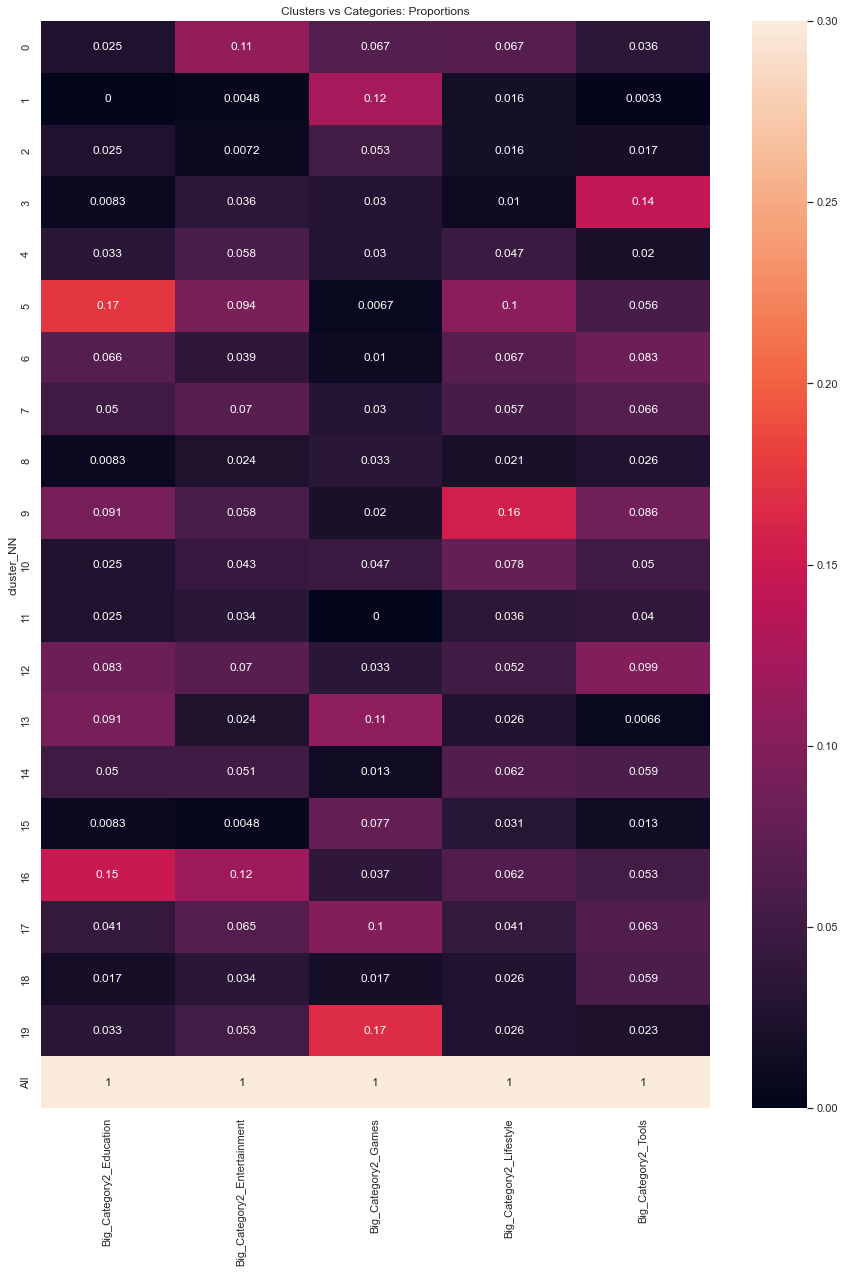

In [96]:
data_w_pca20['cluster_NN']=df_total['Cluster_NN']
table=data_w_pca20.pivot_table(index='cluster_NN',values=['Big_Category2_Education','Big_Category2_Entertainment', 'Big_Category2_Games','Big_Category2_Lifestyle', 'Big_Category2_Tools'],aggfunc='sum',margins=True)
toplot_clusters = pd.DataFrame(table/table.iloc[-1,:])

### Existe Algun tipo de correlacion en las variables 

sns.set(rc = {'figure.figsize':(15,20)})
sns.heatmap(toplot_clusters, annot=True, vmin = 0.0, vmax = 0.3)
plt.title('Clusters vs Categories: Proportions')
plt.show()

In [97]:
df_total['Cluster_NN'].value_counts()

5     114
16    111
9     109
12    103
0      93
17     92
19     88
7      83
6      75
14     72
3      71
10     68
13     61
4      54
18     48
1      43
11     37
8      37
15     36
2      30
Name: Cluster_NN, dtype: int64

Solo Clusters + Interacciones - Redes Neuronales

In [98]:
data_train_NN = pd.concat([data_w_pca20,df_total], axis = 1)
data_train_NN = pd.get_dummies(data_train_NN, prefix=['cluster_NN'], columns=['cluster_NN'], drop_first = True)
#data_train = data_train[data_train['Big_Category2_Games']==1]

In [99]:
data_train_NN = data_train_NN.drop(['App Name', 'App',
       'original_image', 'blue_channel', 'green_channel', 'red_channel',
       'red_channel_scaled', 'blue_channel_scaled', 'green_channel_scaled',
       'blue_channel_PCA', 'green_channel_PCA', 'red_channel_PCA',
       'big_category_2', 'avg_rating','cluster','Rating','Rating Count','cluster','Cluster'], axis = 1)

In [100]:
### Drop Pixel Variables 
data_train_1=data_train_NN.drop(['g'+str(i) for i in range(0,2000)],axis=1)
data_train_1=data_train_1.drop(['b'+str(i) for i in range(0,2000)],axis=1)
data_train_1=data_train_1.drop(['r'+str(i) for i in range(0,2000)],axis=1)
data_train_1.head()

,Maximum Installs,Price,size_norm,version,time_realise,time_updated,time_realise_update,Category_Adventure,Category_Arcade,Category_Art & Design,Category_Auto & Vehicles,Category_Beauty,Category_Board,Category_Books & Reference,Category_Business,Category_Card,Category_Casino,Category_Casual,Category_Comics,Category_Communication,Category_Dating,Category_Education,Category_Educational,Category_Entertainment,Category_Finance,Category_Food & Drink,Category_Health & Fitness,Category_House & Home,Category_Libraries & Demo,Category_Lifestyle,Category_Maps & Navigation,Category_Medical,Category_Music,Category_Music & Audio,Category_News & Magazines,Category_Parenting,Category_Personalization,Category_Photography,Category_Productivity,Category_Puzzle,Category_Racing,Category_Role Playing,Category_Shopping,Category_Simulation,Category_Social,Category_Sports,Category_Strategy,Category_Tools,Category_Travel & Local,Category_Trivia,Category_Video Players & Editors,Category_Weather,Category_Word,Free_True,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Ad Supported_True,In App Purchases_True,Editors Choice_True,Big_Category2_Education,Big_Category2_Entertainment,Big_Category2_Games,Big_Category2_Lifestyle,Big_Category2_Tools,Cluster_NN,cluster_NN_1,cluster_NN_2,cluster_NN_3,cluster_NN_4,cluster_NN_5,cluster_NN_6,cluster_NN_7,cluster_NN_8,cluster_NN_9,cluster_NN_10,cluster_NN_11,cluster_NN_12,cluster_NN_13,cluster_NN_14,cluster_NN_15,cluster_NN_16,cluster_NN_17,cluster_NN_18,cluster_NN_19
0,312649.00000,0.00000,24.00000,5.00000,1842.00000,2.00000,1840.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,12,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1846446.00000,0.00000,118.00000,5.00000,555.00000,14.00000,541.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,155423.00000,0.00000,3.40000,4.10000,548.00000,252.00000,296.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,36807.00000,0.00000,12.00000,4.20000,637.00000,298.00000,339.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,76328.00000,0.00000,11.00000,4.40000,878.00000,664.00000,214.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00

In [101]:
X_train = data_train_1.drop('Maximum Installs', axis = 1)
y_train = data_train_1['Maximum Installs']
y_train_1=pd.DataFrame()
y_train_1['Maximum Installs']=[1 if i>=86534 else 0 for i in y_train]

In [102]:
# Create the interactions 
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_train_1=pd.DataFrame(poly.fit_transform(X_train),columns=poly.get_feature_names(X_train.columns))

In [103]:
a,b=selection(X_train_1,y_train_1,0.4)

/Users/agustinferreira/Desktop/finalproyect-stats/env-stats/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


aca


In [104]:
### New Data Without Correlationed Variables
new_data=X_train_1[b.nombres]
new_data.shape

(1425, 2364)

In [105]:
#L1 with AUC and BIC for model selection

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from math import comb

model_3_variables=[]
model_3_bic=[]
model_3_auc=[]


for i in range(5,100,10):
    ### Cross Validation 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    lst_accu_stratified = []
    lst_bic_stratified = []
    lst_ebic_stratified = []
    log=LogisticRegression(C=(i/100), penalty='l1',solver='liblinear')
    scaler = StandardScaler() 
    scaler.fit(new_data.fillna(0))
    X_scaled=pd.DataFrame(scaler.transform(new_data))
    X_scaled.columns=new_data.columns
    for train_index, test_index in skf.split(new_data, y_train_1):
        x_train_fold, x_test_fold = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train_fold, y_test_fold = y_train_1.iloc[train_index], y_train_1.iloc[test_index]

        log.fit(x_train_fold, y_train_fold['Maximum Installs'])
        predict_test=log.predict_proba(x_test_fold)[:,1]
        lst_accu_stratified.append(roc_auc_score(y_test_fold,predict_test))
        lst_bic_stratified.append(-2*sum(predict_test)+(np.log(len(y_train_fold['Maximum Installs']))*sum(log.coef_[0]!=0)))

   
    print('Lambda: '+str(i/100))
    print('Coef !=0 '+str(sum(log.coef_[0]!=0)))
    model_3_variables.append(sum(log.coef_[0]!=0))
    print(x_train_fold.columns[log.coef_[0]!=0])
    print('CV BIC: '+str(np.mean(lst_bic_stratified)))
    model_3_bic.append(np.mean(lst_bic_stratified))
    print('CV AUC:' +str(np.mean(lst_accu_stratified)))
    model_3_auc.append(np.mean(lst_accu_stratified))

Lambda: 0.05
Coef !=0 75
Index(['Big_Category2_Games cluster_NN_17',
       'time_realise_update Ad Supported_True',
       'Category_Communication cluster_NN_16', 'size_norm time_realise_update',
       'size_norm In App Purchases_True', 'version Category_Simulation',
       'time_realise_update Category_Racing', 'version cluster_NN_16',
       'Category_Adventure cluster_NN_2', 'time_realise cluster_NN_1',
       'Category_Educational Cluster_NN', 'Category_Comics cluster_NN_17',
       'Content Rating_Everyone 10+ Cluster_NN',
       'version Category_Role Playing', 'Free_True',
       'Category_Social Big_Category2_Lifestyle',
       'Category_Books & Reference In App Purchases_True',
       'size_norm Big_Category2_Tools', 'Category_Music Free_True',
       'Category_Books & Reference cluster_NN_6',
       'version Category_Music & Audio', 'Category_Medical Ad Supported_True',
       'Category_Photography Ad Supported_True',
       'Category_Beauty Ad Supported_True', 'Category_To

In [106]:
model3_l1=pd.DataFrame()
model3_l1['model_3_l1_var']=model_3_variables
model3_l1['model_3_l1_auc']=model_3_auc
model3_l1['model_3_l1_bic']=model_3_bic
model3_l1.head()

,model_3_l1_var,model_3_l1_auc,model_3_l1_bic
0,75,0.67975,278.50776
1,240,0.66257,1427.50461
2,280,0.65014,1670.30054
3,297,0.64237,1778.96166
4,305,0.63635,1840.27922


In [107]:
l1_final_results=pd.concat([model2_l1,model3_l1],axis=1)
l1_final_results=l1_final_results.set_index(['lambda'])
l1_final_results.columns=['model1_auc','model1_bic','model1_var','model2_var','model2_auc','model2_bic']

In [108]:
l1_final_results.head()

,model1_auc,model1_bic,model1_var,model2_var,model2_auc,model2_bic
lambda,,,,,,
95,0.68783,372.18181,84,75,0.67975,278.50776
85,0.65294,1692.55079,283,240,0.66257,1427.50461
75,0.64036,1931.80391,319,280,0.65014,1670.30054
65,0.63488,2021.97866,335,297,0.64237,1778.96166
55,0.63127,2079.57179,341,305,0.63635,1840.27922


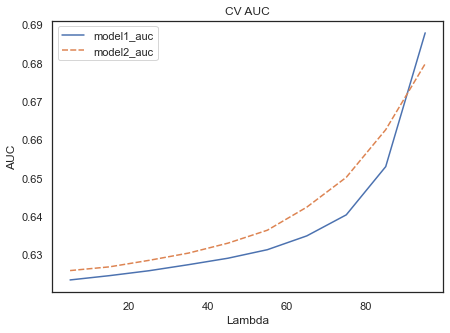

In [110]:
sns.set(rc = {'figure.figsize':(7,5)})
sns.set_style("white")
sns.lineplot(data=l1_final_results[['model1_auc','model2_auc']])
plt.title('CV AUC')
plt.xlabel('Lambda')
plt.ylabel('AUC')
plt.savefig('l1_auc'+".png")
plt.show()

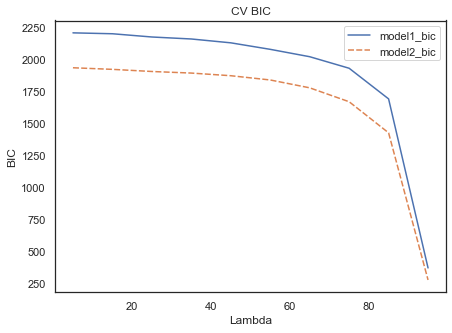

In [111]:
sns.set(rc = {'figure.figsize':(7,5)})
sns.set_style("white")
sns.lineplot(data=l1_final_results[['model1_bic','model2_bic']])
plt.title('CV BIC')
plt.xlabel('Lambda')
plt.ylabel('BIC')
plt.savefig('l1_BIC'+".png")
plt.show()

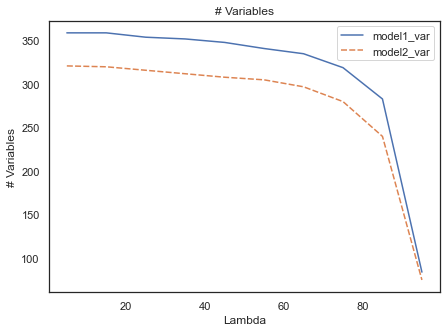

In [112]:
sns.set(rc = {'figure.figsize':(7,5)})
sns.set_style("white")
sns.lineplot(data=l1_final_results[['model1_var','model2_var']])
plt.title('# Variables')
plt.xlabel('Lambda')
plt.ylabel('# Variables')
plt.savefig('l1_var'+".png")
plt.show()

In [113]:
#L2 with AUC and BIC for model selection
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from math import comb

for i in range(5,100,10):
    ### Cross Validation 
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    lst_accu_stratified = []
    lst_bic_stratified = []
    lst_ebic_stratified = []
    log=LogisticRegression(C=(i/100), penalty='l2',solver='liblinear')
    scaler = StandardScaler() 
    scaler.fit(new_data.fillna(0))
    X_scaled=pd.DataFrame(scaler.transform(new_data))
    X_scaled.columns=new_data.columns
    for train_index, test_index in skf.split(new_data, y_train_1):
        x_train_fold, x_test_fold = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train_fold, y_test_fold = y_train_1.iloc[train_index], y_train_1.iloc[test_index]

        log.fit(x_train_fold, y_train_fold['Maximum Installs'])
        predict_test=log.predict_proba(x_test_fold)[:,1]
        lst_accu_stratified.append(roc_auc_score(y_test_fold,predict_test))
        lst_bic_stratified.append(-2*sum(predict_test)+(np.log(len(y_train_fold['Maximum Installs']))*sum(log.coef_[0]!=0)))

    print('Lambda: '+str(i/100))
    print('CV BIC: '+str(np.mean(lst_bic_stratified)))
    print('CV AUC:' +str(np.mean(lst_accu_stratified)))

Lambda: 0.05
CV BIC: 2410.9499698879076
CV AUC:0.6303673764023893
Lambda: 0.15
CV BIC: 2410.424898424987
CV AUC:0.6214805263505918
Lambda: 0.25
CV BIC: 2410.278206194126
CV AUC:0.6182338160417906
Lambda: 0.35
CV BIC: 2410.214393819889
CV AUC:0.6165030086623025
Lambda: 0.45
CV BIC: 2410.180990983954
CV AUC:0.6154221494853314
Lambda: 0.55
CV BIC: 2410.161763413114
CV AUC:0.6145178976834402
Lambda: 0.65
CV BIC: 2410.150011637442
CV AUC:0.6141051709316935
Lambda: 0.75
CV BIC: 2410.1428165898833
CV AUC:0.6137321188476713
Lambda: 0.85
CV BIC: 2410.138616631595
CV AUC:0.6134381405805727
Lambda: 0.95
CV BIC: 2410.136384733731
CV AUC:0.6132232361303974


In [114]:
df_total_NN = pd.concat([data_complete,pd.DataFrame(feat_pca)],axis=1)
df_total_NN.reset_index(inplace=True, drop = True)

In [115]:
data_train_NN = df_total_NN.drop(['App Name', 'App',
       'original_image', 'blue_channel', 'green_channel', 'red_channel',
       'red_channel_scaled', 'blue_channel_scaled', 'green_channel_scaled',
       'blue_channel_PCA', 'green_channel_PCA', 'red_channel_PCA',
       'big_category_2', 'avg_rating','cluster','Rating','Rating Count','cluster','cluster_NN'], axis = 1)

In [116]:
X_train_NN = data_train_NN.drop('Maximum Installs', axis = 1)
y_train_NN = data_train_NN['Maximum Installs']
y_train_NN_1=pd.DataFrame()
y_train_NN_1['Maximum Installs']=[1 if i>=86534 else 0 for i in y_train]

In [117]:
#L1 Cross-Validation all variables red, NO CLUSTER
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from math import comb

for i in range(5,100,10):
    ### Cross Validation 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    lst_accu_stratified = []
    lst_bic_stratified = []
    lst_ebic_stratified = []
    log=LogisticRegression(C=(i/100), penalty='l1',solver='liblinear')
    scaler = StandardScaler() 
    scaler.fit(X_train_NN.fillna(0))
    X_scaled=pd.DataFrame(scaler.transform(X_train_NN))
    X_scaled.columns=X_train_NN.columns
    for train_index, test_index in skf.split(X_train_NN, y_train_NN_1):
        x_train_fold, x_test_fold = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train_fold, y_test_fold = y_train_NN_1.iloc[train_index], y_train_NN_1.iloc[test_index]

        log.fit(x_train_fold, y_train_fold['Maximum Installs'])
        predict_test=log.predict_proba(x_test_fold)[:,1]
        lst_accu_stratified.append(roc_auc_score(y_test_fold,predict_test))
        lst_bic_stratified.append(-2*sum(predict_test)+(np.log(len(y_train_fold['Maximum Installs']))*sum(log.coef_[0]!=0)))

    print('Lambda: '+str(i/100))
    print('Coef !=0 '+str(sum(log.coef_[0]!=0)))
    print(x_train_fold.columns[log.coef_[0]!=0])
    print('CV BIC: '+str(np.mean(lst_bic_stratified)))
    print('CV AUC:' +str(np.mean(lst_accu_stratified)))

Lambda: 0.05
Coef !=0 271
Index([                 'size_norm',        'time_realise_update',
       'Category_Books & Reference',         'Category_Education',
                   'Category_Music',     'Category_Music & Audio',
             'Category_Photography',      'Category_Role Playing',
              'Category_Simulation',            'Category_Social',
       ...
                               1357,                         1362,
                               1367,                         1371,
                               1377,                         1395,
                               1396,                         1404,
                               1405,                         1415],
      dtype='object', length=271)
CV BIC: 1571.6188838054902
CV AUC:0.6207130897271742
Lambda: 0.15
Coef !=0 633
Index([                 'size_norm',        'time_realise_update',
                  'Category_Beauty', 'Category_Books & Reference',
               'Category_Education',         

In [118]:
#L2 Cross-Validation all variables red, NO CLUSTER

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from math import comb

for i in range(5,100,10):
    ### Cross Validation 
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    lst_accu_stratified = []
    lst_bic_stratified = []
    lst_ebic_stratified = []
    log=LogisticRegression(C=(i/100), penalty='l2',solver='liblinear')
    scaler = StandardScaler() 
    scaler.fit(X_train_NN.fillna(0))
    X_scaled=pd.DataFrame(scaler.transform(X_train_NN))
    X_scaled.columns=X_train_NN.columns
    for train_index, test_index in skf.split(X_train_NN, y_train_NN_1):
        x_train_fold, x_test_fold = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train_fold, y_test_fold = y_train_NN_1.iloc[train_index], y_train_NN_1.iloc[test_index]

        log.fit(x_train_fold, y_train_fold['Maximum Installs'])
        predict_test=log.predict_proba(x_test_fold)[:,1]
        lst_accu_stratified.append(roc_auc_score(y_test_fold,predict_test))
        lst_bic_stratified.append(-2*sum(predict_test)+(np.log(len(y_train_fold['Maximum Installs']))*sum(log.coef_[0]!=0)))

    print('Lambda: '+str(i/100))
    print('CV BIC: '+str(np.mean(lst_bic_stratified)))
    print('CV AUC:' +str(np.mean(lst_accu_stratified)))

Lambda: 0.05
CV BIC: 10514.464219701253
CV AUC:0.6833336088518591
Lambda: 0.15
CV BIC: 10514.875132766141
CV AUC:0.6845569111067028
Lambda: 0.25
CV BIC: 10515.088405459659
CV AUC:0.6844221825475546
Lambda: 0.35
CV BIC: 10515.240976532836
CV AUC:0.6847652031122574
Lambda: 0.45
CV BIC: 10515.363313203741
CV AUC:0.6837639687892614
Lambda: 0.55
CV BIC: 10515.466271858113
CV AUC:0.6840218541294717
Lambda: 0.65
CV BIC: 10515.556985977568
CV AUC:0.6841439088364302
Lambda: 0.75
CV BIC: 10515.638548797493
CV AUC:0.6840485794264806
Lambda: 0.85
CV BIC: 10515.713037333082
CV AUC:0.6840653860565585
Lambda: 0.95
CV BIC: 10515.781165501083
CV AUC:0.6844574489188654


XGBOOST WITHOUT CLUSTERS, JUST SELECTING DATA FROM PREPROCESSING WITH THE NN

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier()

parameters = {'nthread':[1], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.05,0.1,0.01], #so called `eta` value
              'max_depth': [2,4,6], #also tried with 8 and 10
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8], #tried 0.5 and 0.3
              'colsample_bytree': [0.3],
              'n_estimators': [100,300,500], #number of trees, also tried with 50
              'missing':[-285], #missing kept equally to age 
              'seed': [1337]}


xg_reg = GridSearchCV(xgb_model,
                      parameters,
                      n_jobs=3, 
                      cv=5,
                      #cv=StratifiedKFold(dtrain['QuoteConversion_Flag'], n_folds=5, shuffle=True), 
                      scoring='roc_auc',
                      verbose=3)


xg_reg.fit(X_train_NN,y_train_NN)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=2,
              min_child_weight=11, missing=-285, monotone_constraints='()',
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              predictor='auto', random_state=1337, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=1337, silent=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, ...) 
              
              0.6762434748350242

XGBOOST INCLUDING CLUSTERS WITH DATA FROM PREPROCESSING WITH THE NN

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier()

parameters = {'nthread':[1], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.05,0.1,0.01], #so called `eta` value
              'max_depth': [2,4,6], #also tried with 8 and 10
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8], #tried 0.5 and 0.3
              'colsample_bytree': [0.3],
              'n_estimators': [100,300,500], #number of trees, also tried with 50
              'missing':[-285], #missing kept equally to age 
              'seed': [1337]}


xg_reg_clusters = GridSearchCV(xgb_model,
                      parameters,
                      n_jobs=3, 
                      cv=5,
                      #cv=StratifiedKFold(dtrain['QuoteConversion_Flag'], n_folds=5, shuffle=True), 
                      scoring='roc_auc',
                      verbose=3)


xg_reg_clusters.fit(X_train_1,y_train_1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=11, missing=-285, monotone_constraints='()',
              n_estimators=300, n_jobs=1, nthread=1, num_parallel_tree=1,
              predictor='auto', random_state=1337, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=1337, silent=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, ...)

              0.7105486063232542